# Data Literacy Notebook

Requires data to be loaded from the GCloud bucket.

Required files (in the same directory as this notebook):
- `departure-data-reader-key.json` - GCS service account key
- `trias.py` - TRIAS API client module

Installing dependencies

In [112]:
!pip install google-cloud-storage pandas plotly networkx requests tueplots -q

# GCloud data loading

## Initialize Google Cloud Storage Client

Sets up authentication using a service account key file and connects to the `departure_data` bucket where all transit data is stored.

In [113]:
import os
import pandas as pd
from google.cloud import storage

# Set the path to your service account key file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'departure-data-reader-key.json'

# Initialize the storage client
client = storage.Client()
bucket_name = 'departure_data'
bucket = client.get_bucket(bucket_name)

print("Google Cloud Storage client initialized successfully.")

Google Cloud Storage client initialized successfully.


## List Available Data Files

Scans the bucket and filters for departure and trip_calls CSV files. These files contain timestamped snapshots of real-time transit data.

In [114]:
# List all files in the bucket and filter for departure files
blobs_iterator = bucket.list_blobs()
blobs = list(blobs_iterator) # Convert iterator to a list

departure_files = [blob.name for blob in blobs if 'departures' in blob.name and blob.name.endswith('.csv')]
#lines_files = [blob.name for blob in blobs if 'lines' in blob.name and blob.name.endswith('.csv')]
trip_files = [blob.name for blob in blobs if 'trip_calls' in blob.name and blob.name.endswith('.csv')]

print(f"Found {len(departure_files)} departure files")
#print(f"Found {len(lines_files)} lines files")
print(f"Found {len(trip_files)} trip files")

Found 1550 departure files
Found 1550 trip files


## Parallel Data Loading Function

Defines `download_and_combine_data()` which downloads CSV files from GCS in parallel using a thread pool. Extracts timestamps from filenames and combines all data into a single DataFrame.

In [115]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import io, re
import pandas as pd

def download_and_combine_data(file_list, max_workers=20):
    total_files = len(file_list)
    if total_files == 0:
        print("No files to process.")
        return pd.DataFrame()

    print(f"Processing {total_files} files in parallel (max_workers={max_workers})...")

    def _load_single_file(file_name):
        blob = bucket.blob(file_name)
        data = blob.download_as_string()
        df = pd.read_csv(io.BytesIO(data))

        # Extract timestamp from filename and add as a column
        match = re.search(r'(\d{8}_\d{6})', file_name)
        if match:
            timestamp_str = match.group(1)
            df['timestamp'] = pd.to_datetime(timestamp_str, format='%Y%m%d_%H%M%S')
        else:
            df['timestamp'] = pd.NaT

        return df

    dfs = []
    # Use at most total_files workers
    workers = min(max_workers, total_files)

    with ThreadPoolExecutor(max_workers=workers) as executor:
        future_to_file = {
            executor.submit(_load_single_file, file_name): file_name
            for file_name in file_list
        }

        for i, future in enumerate(as_completed(future_to_file), 1):
            file_name = future_to_file[future]
            try:
                df = future.result()
                dfs.append(df)
            except Exception as e:
                # Don't crash everything for one bad file, just log it
                print(f"Error processing {file_name}: {e}")
            if i % 100 == 0 or i == total_files:
                print(f"Processed {i}/{total_files} files...")

    if not dfs:
        print("No dataframes were loaded successfully.")
        return pd.DataFrame()

    combined_data = pd.concat(dfs, ignore_index=True)

    print(f"\nCombined {total_files} files into DataFrame with {len(combined_data)} rows.")
    if 'timestamp' in combined_data.columns:
        print(f"Date range: {combined_data['timestamp'].min()} to {combined_data['timestamp'].max()}")

    return combined_data

## Load Departure Data

Downloads and combines all 1,111 departure files into `all_departure_data`. Each row represents a scheduled departure with planned/estimated times, delays, and weather conditions.

In [116]:
all_departure_data = download_and_combine_data(departure_files)
# Print data
display(all_departure_data.head(10))

Processing 1550 files in parallel (max_workers=20)...
Processed 100/1550 files...
Processed 200/1550 files...
Processed 300/1550 files...
Processed 400/1550 files...
Processed 500/1550 files...
Processed 600/1550 files...
Processed 700/1550 files...
Processed 800/1550 files...
Processed 900/1550 files...
Processed 1000/1550 files...
Processed 1100/1550 files...
Processed 1200/1550 files...
Processed 1300/1550 files...
Processed 1400/1550 files...
Processed 1500/1550 files...
Processed 1550/1550 files...

Combined 1550 files into DataFrame with 258736 rows.
Date range: 2025-11-11 17:00:32 to 2026-01-26 09:00:33


,stop_id,stop_point_ref,stop_name,planned_time,estimated_time,line_name,destination,platform,journey_ref,operating_day_ref,...,wind_speed_ms,wind_direction_deg,cloud_cover,pressure_hpa,relative_humidity,condition,icon,weather_source_id,weather_station_name,timestamp
0,de:08416:11000,de:08416:11000,Tübingen Hauptbahnhof,2025-11-12 00:40:00,NaN,N177,Genova (I) Fanti d'Italia / Principe F.S.,NaN,bus:02N17:7:H:f5z:1,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
1,de:08416:10044,de:08416:10044:0:1,Tübingen Neckarhalde,2025-11-12 00:07:12,2025-11-12 00:07:12,6,Tübingen Hirschauer Straße,NaN,tub:09006::H:j25:225,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
2,de:08416:10044,de:08416:10044:0:4,Tübingen Neckarhalde,2025-11-12 00:13:54,2025-11-12 00:13:54,6,Tübingen Hauptbahnhof,NaN,tub:09006::R:j25:37,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
3,de:08416:11000,de:08416:11000:12:F,Tübingen Hauptbahnhof,2025-11-12 00:02:00,2025-11-12 00:02:00,4,Tübingen Wennf. Garten,Bstg. F,tub:09004::H:j25:400,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
4,de:08416:11000,de:08416:11000:12:F,Tübingen Hauptbahnhof,2025-11-12 01:00:00,NaN,N95,Tübingen Hauptbahnhof,Bstg. F,tub:09095::H:j25:1,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
5,de:08416:11000,de:08416:11000:11:B,Tübingen Hauptbahnhof,2025-11-12 00:02:00,2025-11-12 00:02:00,5,Tübingen WHO Ahornweg,Bstg. B,tub:09005::R:j25:160,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
6,de:08416:11000,de:08416:11000:11:B,Tübingen Hauptbahnhof,2025-11-12 00:24:00,NaN,N94,Tübingen Hauptbahnhof,Bstg. B,tub:09094::H:j25:1,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
7,de:08416:11000,de:08416:11000:11:C,Tübingen Hauptbahnhof,2025-11-12 00:03:00,2025-11-12 00:03:00,1,Pfrondorf Lusstraße,Bstg. C,tub:09001::R:j25:708,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
8,de:08416:11000,de:08416:11000:11:C,Tübingen Hauptbahnhof,2025-11-12 01:00:00,NaN,N91,Tübingen Hauptbahnhof,Bstg. C,tub:09091::H:j25:1,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22
9,de:08416:11000,de:08416:11000:13:K,Tübingen Hauptbahnhof,2025-11-12 00:04:00,2025-11-12 00:04:00,8,Hagelloch Dornäckerweg,Bstg. K,tub:09008::R:j25:328,2025-11-12,...,11.9,140.0,88.0,1017.8,95,dry,cloudy,64012,Rottenburg-Kiebingen,2025-11-11 23:00:22


In [117]:
# =============================================================================
# DATA FILTERING CONTROLS
# =============================================================================
# The city changed bus schedules on December 14, 2025.
# Use these controls to filter data before/after the schedule change.

import pandas as pd
import re

# --- CONTROL FLAGS ---
SPLIT_BY_SCHEDULE_CHANGE = False  # Set True to filter by schedule change date
USE_DATA_BEFORE_CHANGE = True     # If splitting: True = before Dec 14, False = after Dec 14

SCHEDULE_CHANGE_DATE = pd.Timestamp('2025-12-14')

# --- OUTLIER FILTERING ---
FILTER_DELAY_OUTLIERS = True      # Set True to remove extreme delay outliers
DELAY_MAX_THRESHOLD = 90          # Maximum plausible delay in minutes (values above are data errors)

# --- TRAIN/NON-BUS FILTERING ---
FILTER_TRAINS = True              # Set True to remove trains and keep only buses

# Train line patterns to exclude (RB, RE, MEX = regional/metro trains)
TRAIN_PATTERNS = [
    r'^RB\s*\d*',    # RB 6, RB 63, RB 66, RB 74, RB63
    r'^RE\s*\d*',    # RE 6
    r'^MEX\d*',      # MEX12, MEX18
    r'^IRE\s*\d*',   # IRE (if any)
    r'^IC\s*\d*',    # IC trains
    r'^ICE\s*\d*',   # ICE trains
    r'^S\d+$',       # S-Bahn (S1, S2, etc.)
]

def is_train_line(line_name):
    """Check if a line name matches train patterns."""
    if pd.isna(line_name):
        return False
    line_str = str(line_name).strip()
    for pattern in TRAIN_PATTERNS:
        if re.match(pattern, line_str, re.IGNORECASE):
            return True
    return False

# --- Apply date filtering ---
if SPLIT_BY_SCHEDULE_CHANGE:
    if USE_DATA_BEFORE_CHANGE:
        date_filter = all_departure_data['timestamp'] < SCHEDULE_CHANGE_DATE
        period_label = f"BEFORE schedule change ({SCHEDULE_CHANGE_DATE.date()})"
    else:
        date_filter = all_departure_data['timestamp'] >= SCHEDULE_CHANGE_DATE
        period_label = f"AFTER schedule change ({SCHEDULE_CHANGE_DATE.date()})"

    all_departure_data = all_departure_data[date_filter].copy()
    print(f"✓ Filtered departure data: {period_label}")
    print(f"  Rows: {len(all_departure_data):,}")
    print(f"  Date range: {all_departure_data['timestamp'].min()} to {all_departure_data['timestamp'].max()}")
else:
    print("✓ Using ALL departure data (no date filtering)")
    print(f"  Rows: {len(all_departure_data):,}")
    print(f"  Date range: {all_departure_data['timestamp'].min()} to {all_departure_data['timestamp'].max()}")

# --- Apply train filtering ---
if FILTER_TRAINS:
    train_mask = all_departure_data['line_name'].apply(is_train_line)
    n_trains = train_mask.sum()
    
    if n_trains > 0:
        train_lines = all_departure_data[train_mask]['line_name'].unique()
        print(f"\n⚠ Found {n_trains:,} train departures to filter out")
        print(f"  Train lines removed: {sorted(train_lines)}")
        
        all_departure_data = all_departure_data[~train_mask].copy()
        print(f"✓ Removed {n_trains:,} train departures (keeping buses only)")
        print(f"  Rows after filtering: {len(all_departure_data):,}")
    else:
        print("\n✓ No train lines found in data")
else:
    print("\n✓ Train filtering disabled (including all transport types)")

# --- Apply outlier filtering ---
if FILTER_DELAY_OUTLIERS:
    outliers_before = len(all_departure_data)
    outlier_mask = all_departure_data['delay_minutes'] > DELAY_MAX_THRESHOLD
    n_outliers = outlier_mask.sum()

    if n_outliers > 0:
        print(f"\n⚠ Found {n_outliers:,} outliers with delay > {DELAY_MAX_THRESHOLD} min")
        # Show sample of outliers before removing
        outlier_sample = all_departure_data[outlier_mask][['planned_time', 'stop_name', 'line_name', 'delay_minutes']].head(5)
        print(f"  Sample outliers (likely data errors):")
        for _, row in outlier_sample.iterrows():
            print(f"    {row['planned_time']} | {row['line_name']} | {row['stop_name']} | {row['delay_minutes']:.1f} min")

        all_departure_data = all_departure_data[~outlier_mask].copy()
        print(f"✓ Removed {n_outliers:,} outliers (delay > {DELAY_MAX_THRESHOLD} min)")
        print(f"  Rows after filtering: {len(all_departure_data):,}")
    else:
        print(f"\n✓ No outliers found (threshold: {DELAY_MAX_THRESHOLD} min)")
else:
    print("\n✓ Outlier filtering disabled (using raw data)")

# --- Summary ---
print(f"\n{'='*60}")
print(f"FINAL DEPARTURE DATA: {len(all_departure_data):,} rows")
print(f"Unique lines: {all_departure_data['line_name'].nunique()}")
print(f"Lines: {sorted(all_departure_data['line_name'].dropna().unique())}")
print(f"{'='*60}")

✓ Using ALL departure data (no date filtering)
  Rows: 258,736
  Date range: 2025-11-11 17:00:32 to 2026-01-26 09:00:33

⚠ Found 13,610 train departures to filter out
  Train lines removed: ['MEX12', 'MEX18', 'RB 6', 'RB 63', 'RB 66', 'RB 74', 'RB63', 'RB63E', 'RE 6', 'RE6', 'S1']
✓ Removed 13,610 train departures (keeping buses only)
  Rows after filtering: 245,126

⚠ Found 106 outliers with delay > 90 min
  Sample outliers (likely data errors):
    2025-11-14 17:30:00 | 7 | Tübingen Hauptbahnhof | 172.5 min
    2025-11-14 17:32:24 | 7 | Tübingen Neckarbrücke | 172.5 min
    2025-11-12 00:00:12 | 5 | Tübingen Hegelstraße | 162.0 min
    2025-11-18 17:44:00 | 5 | Tübingen Hauptbahnhof | 217.8 min
    2025-11-18 17:38:54 | 5 | Tübingen Neckarbrücke | 217.9 min
✓ Removed 106 outliers (delay > 90 min)
  Rows after filtering: 245,020

FINAL DEPARTURE DATA: 245,020 rows
Unique lines: 68
Lines: ['008', '1', '10', '101', '11', '111', '12', '13', '16', '17', '18', '19', '2', '21', '22', '283',

## Load Trip Data

Downloads and combines all 1,111 trip_calls files into `all_trip_data`. Contains stop-by-stop journey information including arrival/departure times and delays at each stop in a trip sequence.

# Visualizations

In [118]:
# =============================================================================
# TUEPLOTS: Academic Publication-Quality Figure Styling
# =============================================================================
# tueplots provides pre-configured styles for scientific publications.
# Using ICML 2024 template (latest available ICML style).

import matplotlib.pyplot as plt
from tueplots import bundles, axes, figsizes

# Configure tueplots for ICML 2024 papers
# Available: icml2022, icml2024, neurips2021-2024, iclr2023-2024, aistats, jmlr, etc.
TUEPLOTS_STYLE = {
    **bundles.icml2024(usetex=False, family="serif"),  # ICML 2024 style
    **axes.lines(),  # Clean axis styling
    "figure.dpi": 150,  # Higher resolution for notebook display
}

# Apply globally
plt.rcParams.update(TUEPLOTS_STYLE)

print("✓ tueplots ICML 2024 styling applied")
print(f"  Figure size: {plt.rcParams['figure.figsize']}")
print(f"  Font family: {plt.rcParams['font.family']}")
print(f"  Font size: {plt.rcParams['font.size']}")

✓ tueplots ICML 2024 styling applied
  Figure size: [3.25, 2.0086104634371584]
  Font family: ['serif']
  Font size: 8.0


## Exploratory Data Analysis: 4-Panel Visualization

Creates a comprehensive overview of the departure data:
- **Top-left**: Histogram of delay distribution (capped at ±30 min)
- **Top-right**: Average delay by hour of day (reveals peak delay times)
- **Bottom-left**: Top 10 busiest stops by departure count
- **Bottom-right**: Average delay by weather condition

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/163009430.py:143: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


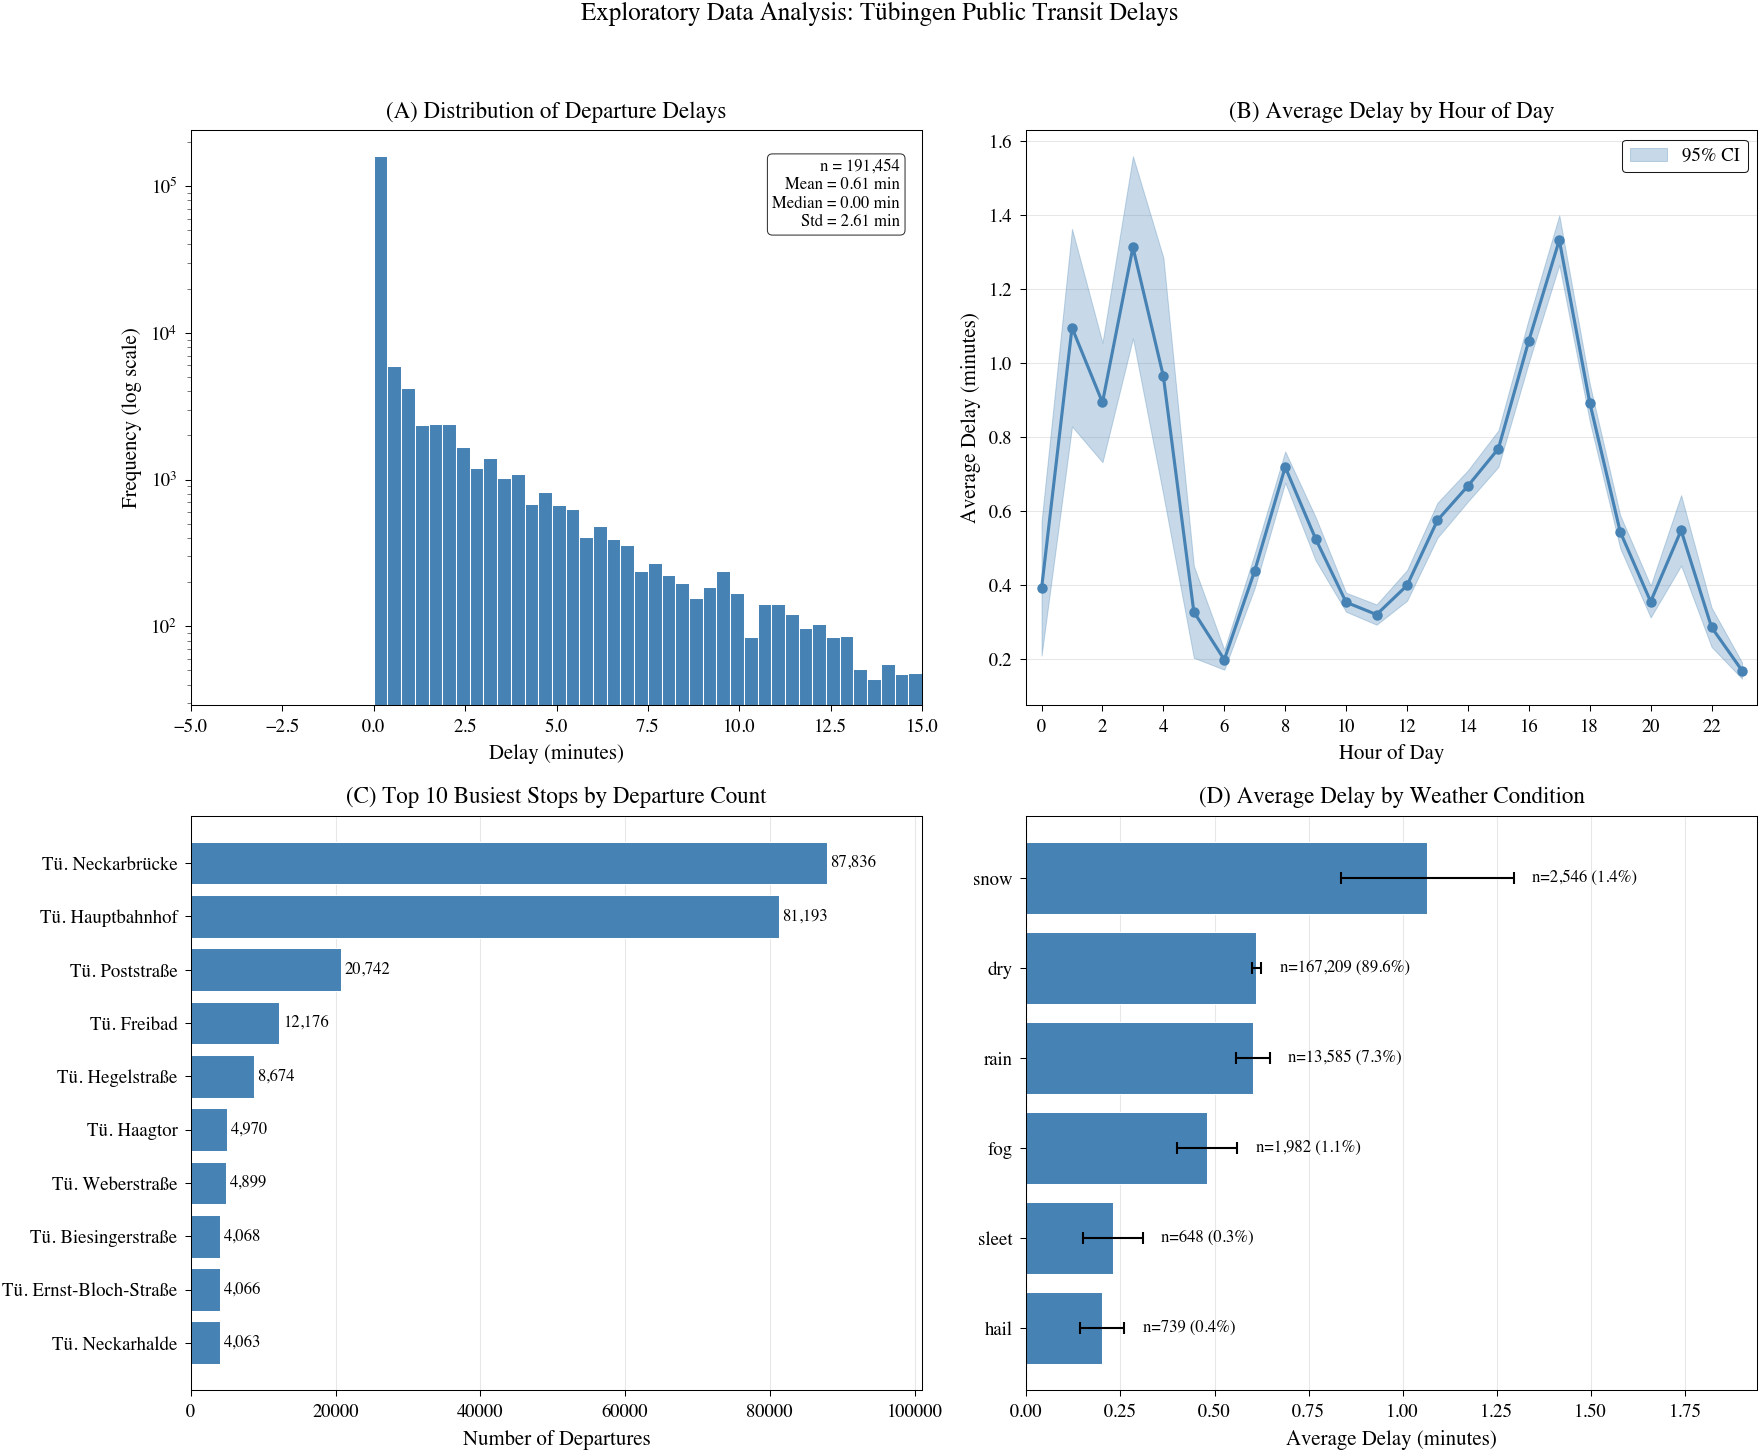

Figure saved as 'eda_4panel.png' and 'eda_4panel.pdf'


In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================================================================
# Academic style settings for publication-quality figures
# =============================================================================
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 12,
})

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Exploratory Data Analysis: Tübingen Public Transit Delays', fontweight='bold', y=0.98)

# =============================================================================
# Panel A: Delay Distribution
# - Zoomed to -5 to 15 min where most data lies (avoids long tail distortion)
# - LOG SCALE on y-axis to show distribution shape despite high peak at 0
# =============================================================================
ax = axes[0, 0]
delays = all_departure_data['delay_minutes'].dropna()

# Focus on -5 to 15 minutes where most data lies
delays_filtered = delays[(delays >= -5) & (delays <= 15)]

# Use log scale to handle the spike at 0
ax.hist(delays_filtered, bins=40, color='steelblue', edgecolor='white', linewidth=0.5, log=True)

ax.set_title('(A) Distribution of Departure Delays', fontweight='bold')
ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Frequency (log scale)')
ax.set_xlim(-5, 15)

# Summary statistics annotation
stats_text = f'n = {len(delays):,}\nMean = {delays.mean():.2f} min\nMedian = {delays.median():.2f} min\nStd = {delays.std():.2f} min'
ax.text(0.97, 0.95, stats_text, transform=ax.transAxes, fontsize=8, verticalalignment='top',
        horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# =============================================================================
# Panel B: Average Delay by Hour of Day
# - Shows 95% confidence intervals to indicate statistical uncertainty
# - Helps identify peak delay hours (rush hour effects)
# - Hypothesis: Delays increase during rush hours (7-9, 16-18)
# =============================================================================
ax = axes[0, 1]
all_departure_data['hour'] = pd.to_datetime(all_departure_data['planned_time']).dt.hour

# Calculate mean and 95% CI per hour
hourly_stats = all_departure_data.groupby('hour')['delay_minutes'].agg(['mean', 'std', 'count'])
hourly_stats['se'] = hourly_stats['std'] / np.sqrt(hourly_stats['count'])
hourly_stats['ci95'] = 1.96 * hourly_stats['se']

ax.fill_between(hourly_stats.index,
                hourly_stats['mean'] - hourly_stats['ci95'],
                hourly_stats['mean'] + hourly_stats['ci95'],
                alpha=0.3, color='steelblue', label='95% CI')
ax.plot(hourly_stats.index, hourly_stats['mean'], 'o-', color='steelblue', linewidth=1.5, markersize=4)

ax.set_title('(B) Average Delay by Hour of Day', fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Delay (minutes)')
ax.set_xticks(range(0, 24, 2))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# =============================================================================
# Panel C: Top 10 Busiest Stops
# - Shows departure frequency to understand data distribution
# - Hauptbahnhof dominates as expected (central hub)
# - Useful for understanding which stops drive aggregate statistics
# =============================================================================
ax = axes[1, 0]
stop_counts = all_departure_data['stop_name'].value_counts().head(10)

# Shorten stop names for readability (remove "Tübingen " prefix)
short_names = [name.replace('Tübingen ', 'Tü. ') for name in stop_counts.index]

bars = ax.barh(range(len(stop_counts)), stop_counts.values, color='steelblue', edgecolor='white')
ax.set_yticks(range(len(stop_counts)))
ax.set_yticklabels(short_names)
ax.invert_yaxis()

ax.set_title('(C) Top 10 Busiest Stops by Departure Count', fontweight='bold')
ax.set_xlabel('Number of Departures')
ax.set_ylabel('')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, stop_counts.values)):
    ax.text(val + 500, i, f'{val:,}', va='center', fontsize=8)

ax.set_xlim(0, stop_counts.max() * 1.15)
ax.grid(axis='x', alpha=0.3)

# =============================================================================
# Panel D: Average Delay by Weather Condition
# - Shows MEAN delay with 95% CI error bars
# - Labels placed OUTSIDE plot area to avoid overlap with bars
# - Sample sizes shown to assess reliability of estimates
# =============================================================================
ax = axes[1, 1]

# Group by weather condition and compute statistics
weather_stats = all_departure_data.groupby('condition')['delay_minutes'].agg(['mean', 'std', 'count'])
weather_stats = weather_stats[weather_stats['count'] >= 100]  # Filter conditions with <100 samples
weather_stats['se'] = weather_stats['std'] / np.sqrt(weather_stats['count'])
weather_stats['ci95'] = 1.96 * weather_stats['se']
weather_stats = weather_stats.sort_values('mean', ascending=True)

# Calculate percentage of total observations per condition
total_obs = weather_stats['count'].sum()
weather_stats['pct'] = 100 * weather_stats['count'] / total_obs

y_pos = range(len(weather_stats))
bars = ax.barh(y_pos, weather_stats['mean'], xerr=weather_stats['ci95'],
               color='steelblue', edgecolor='white', capsize=3, error_kw={'linewidth': 1})
ax.set_yticks(y_pos)
ax.set_yticklabels(weather_stats.index)

ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_title('(D) Average Delay by Weather Condition', fontweight='bold')
ax.set_xlabel('Average Delay (minutes)')
ax.set_ylabel('')
ax.grid(axis='x', alpha=0.3)

# Extend x-axis to make room for labels on the right
x_max = weather_stats['mean'].max() + weather_stats['ci95'].max()
ax.set_xlim(ax.get_xlim()[0], x_max * 1.5)

# Place labels to the RIGHT of the error bars, with clear black font
for i, (idx, row) in enumerate(weather_stats.iterrows()):
    label_x = row['mean'] + row['ci95'] + 0.05  # Position after error bar
    ax.text(label_x, i, f'n={int(row["count"]):,} ({row["pct"]:.1f}%)',
            va='center', ha='left', fontsize=8, fontweight='normal', color='black')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('plots/eda_4panel.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.savefig('plots/eda_4panel.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved as 'eda_4panel.png' and 'eda_4panel.pdf'")

EDA Extension 1

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/2404676608.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


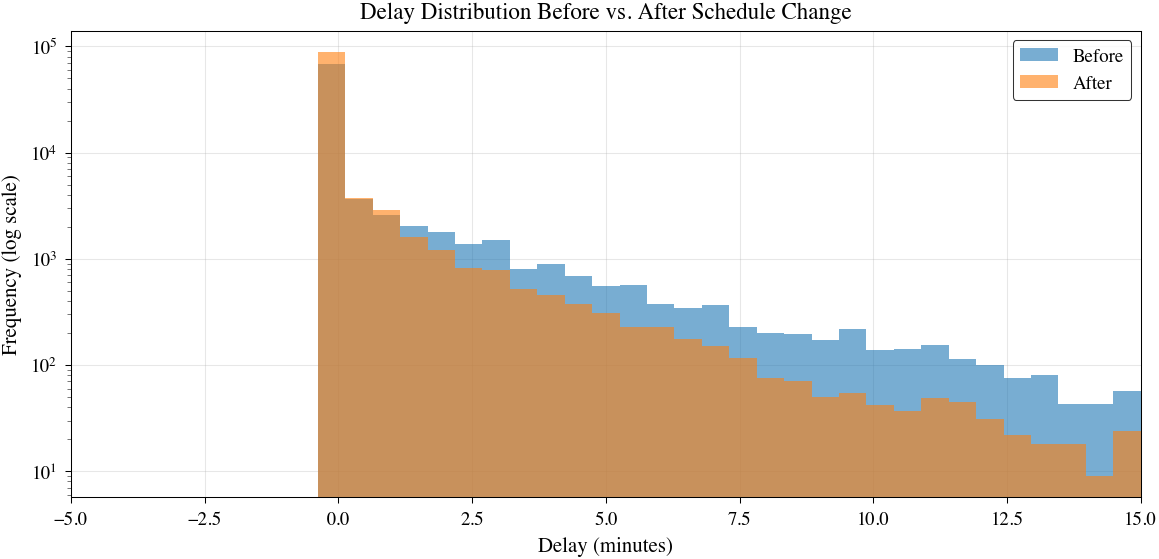

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/2404676608.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


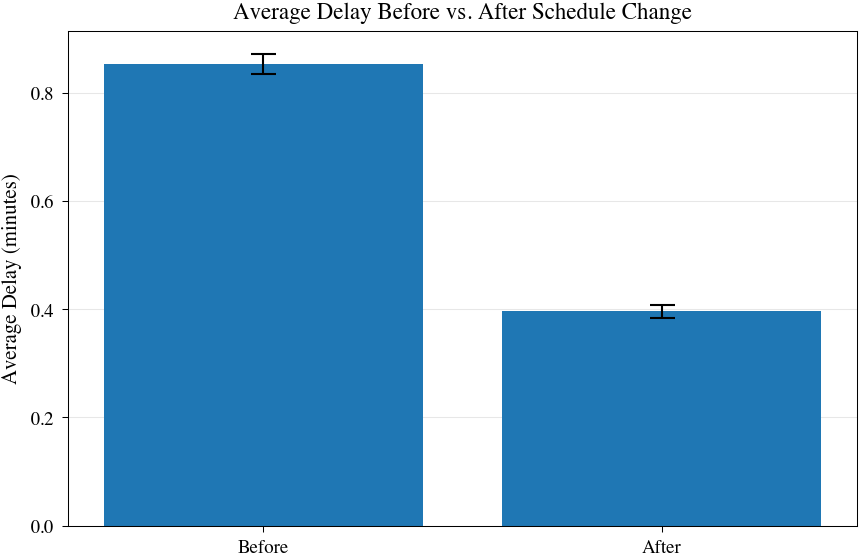

In [120]:
schedule_date = pd.Timestamp('2025-12-14')

before = all_departure_data[all_departure_data['timestamp'] < schedule_date]
after  = all_departure_data[all_departure_data['timestamp'] >= schedule_date]

# Distribution Comparison
fig, ax = plt.subplots(figsize=(8, 4))

bins = np.linspace(-5, 15, 40)

ax.hist(before['delay_minutes'], bins=bins, alpha=0.6, label='Before', log=True)
ax.hist(after['delay_minutes'],  bins=bins, alpha=0.6, label='After',  log=True)

ax.set_title('Delay Distribution Before vs. After Schedule Change', fontweight='bold')
ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Frequency (log scale)')
ax.legend()
ax.set_xlim(-5, 15)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext1_schedule_change_distribution.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext1_schedule_change_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Mean delay comparison with CI
def mean_ci(x):
    return pd.Series({
        'mean': x.mean(),
        'ci95': 1.96 * x.std() / np.sqrt(len(x))
    })

compare = pd.concat([
    before['delay_minutes'].pipe(mean_ci),
    after['delay_minutes'].pipe(mean_ci)
], axis=1)

compare.columns = ['Before', 'After']

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(compare.columns, compare.loc['mean'],
       yerr=compare.loc['ci95'], capsize=6)

ax.set_ylabel('Average Delay (minutes)')
ax.set_title('Average Delay Before vs. After Schedule Change', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext1_schedule_change_mean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext1_schedule_change_mean.png', dpi=150, bbox_inches='tight')
plt.show()

EDA Extension 2

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/1046343897.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


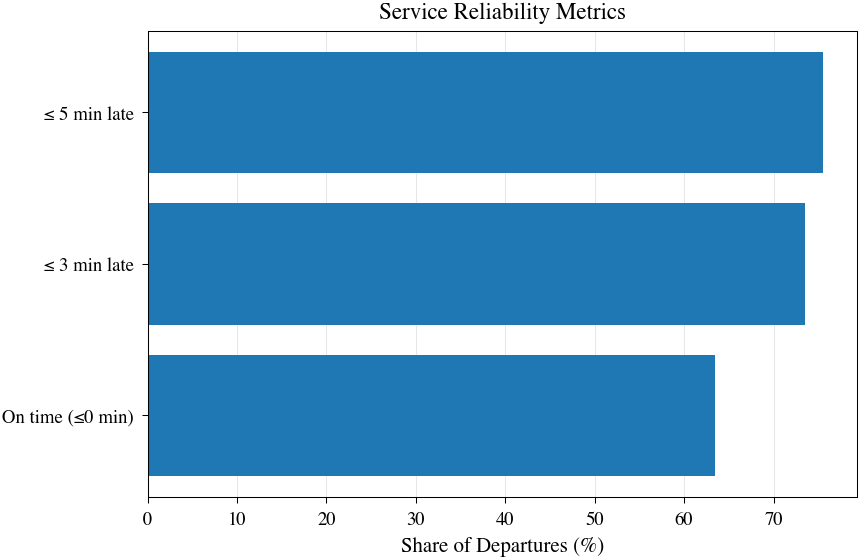

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/1046343897.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


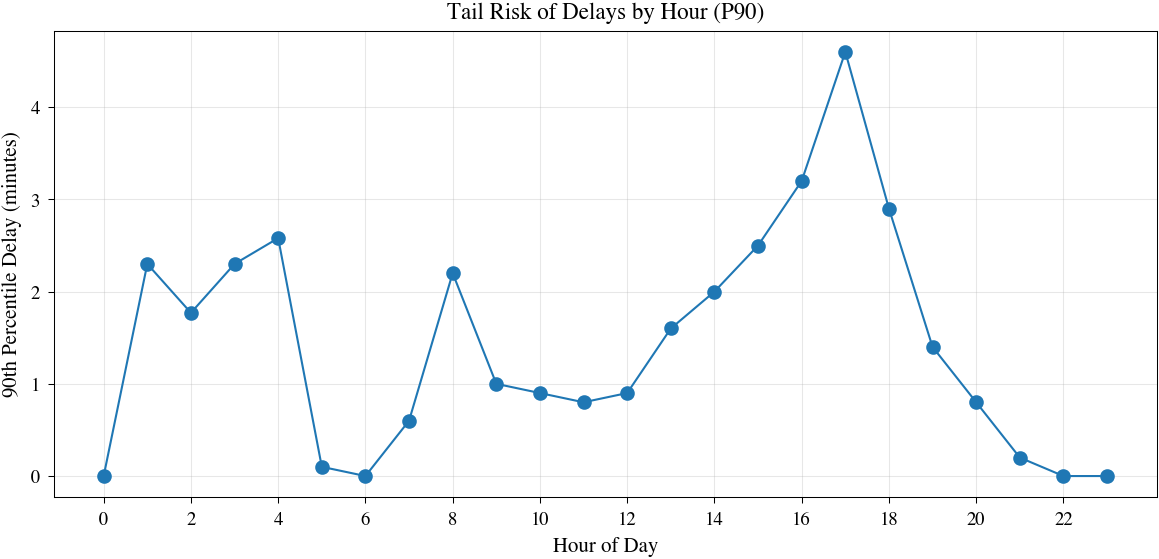

In [121]:
# On-time performance
reliability = {
    'On time (≤0 min)': (all_departure_data['delay_minutes'] <= 0).mean(),
    '≤ 3 min late':    (all_departure_data['delay_minutes'] <= 3).mean(),
    '≤ 5 min late':    (all_departure_data['delay_minutes'] <= 5).mean()
}

rel_df = pd.DataFrame.from_dict(reliability, orient='index', columns=['Share'])
rel_df['Share'] *= 100

fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(rel_df.index, rel_df['Share'])
ax.set_xlabel('Share of Departures (%)')
ax.set_title('Service Reliability Metrics', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext2_reliability_metrics.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext2_reliability_metrics.png', dpi=150, bbox_inches='tight')
plt.show()


# 90th percentile delay by hour
p90_hour = all_departure_data.groupby('hour')['delay_minutes'].quantile(0.9)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(p90_hour.index, p90_hour.values, marker='o')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('90th Percentile Delay (minutes)')
ax.set_title('Tail Risk of Delays by Hour (P90)', fontweight='bold')
ax.set_xticks(range(0, 24, 2))
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext2_p90_delay_by_hour.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext2_p90_delay_by_hour.png', dpi=150, bbox_inches='tight')
plt.show()

EDA Extension 3

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/1529691177.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


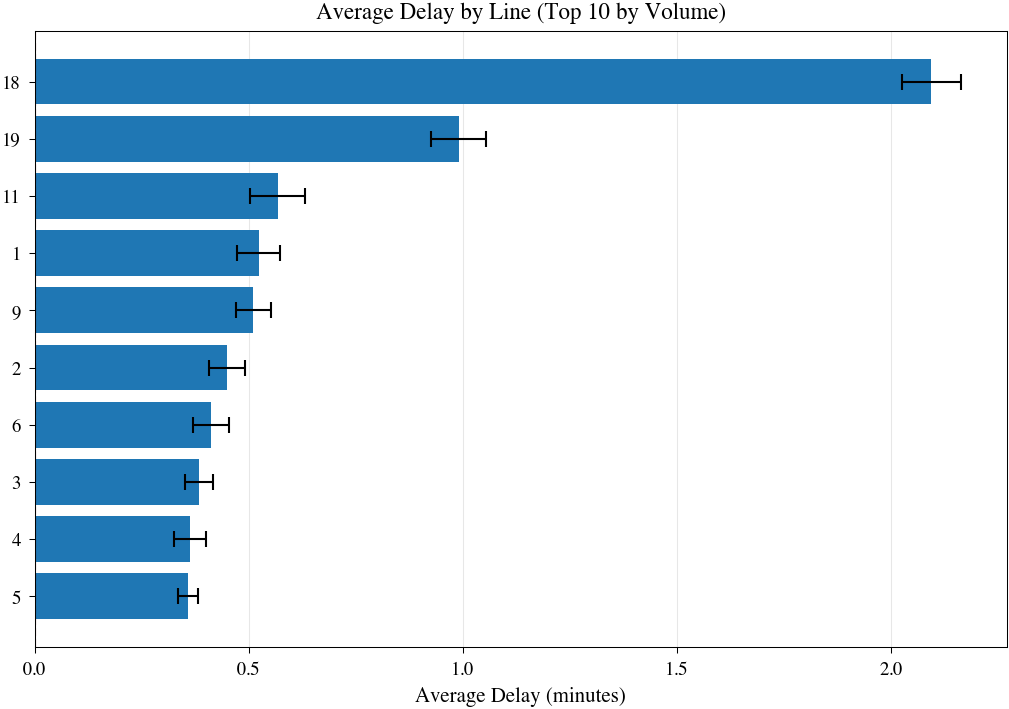

In [122]:
# Top 10 Lines by Volume
top_lines = all_departure_data['line_name'].value_counts().head(10).index
line_stats = all_departure_data[all_departure_data['line_name'].isin(top_lines)] \
    .groupby('line_name')['delay_minutes'] \
    .agg(['mean', 'std', 'count'])

line_stats['ci95'] = 1.96 * line_stats['std'] / np.sqrt(line_stats['count'])
line_stats = line_stats.sort_values('mean')

fig, ax = plt.subplots(figsize=(7, 5))

ax.barh(line_stats.index, line_stats['mean'],
        xerr=line_stats['ci95'], capsize=4)

ax.axvline(0, color='darkred', linestyle='--', linewidth=1)
ax.set_xlabel('Average Delay (minutes)')
ax.set_title('Average Delay by Line (Top 10 by Volume)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/eda_ext3_delay_by_line.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext3_delay_by_line.png', dpi=150, bbox_inches='tight')
plt.show()

EDA Extension 4

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/618897187.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=30)
/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/618897187.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


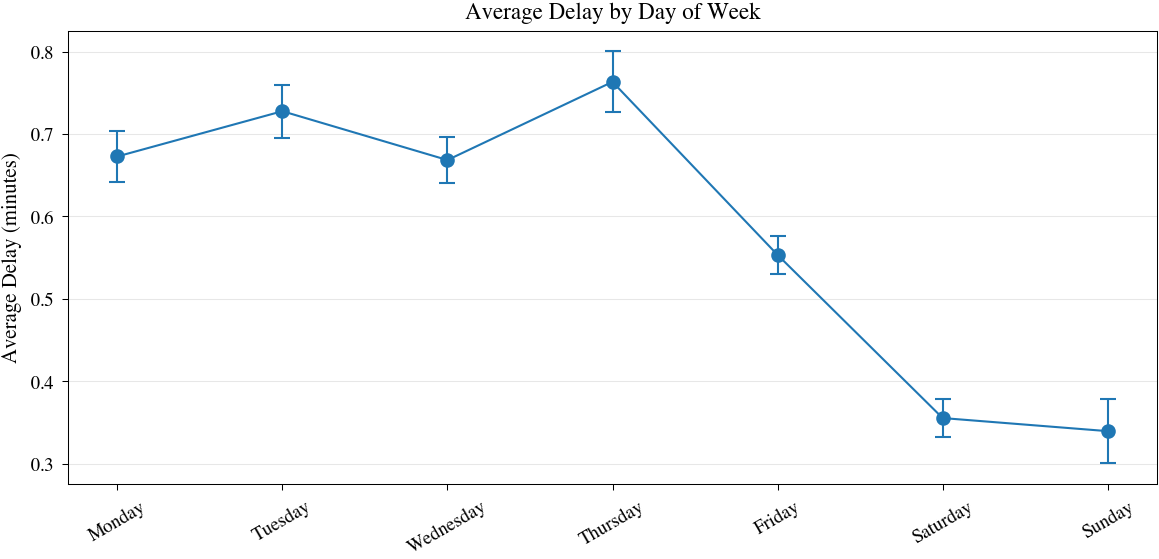

In [123]:
all_departure_data['weekday'] = all_departure_data['timestamp'].dt.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_stats = all_departure_data.groupby('weekday')['delay_minutes'] \
    .agg(['mean', 'std', 'count']).reindex(order)

weekday_stats['ci95'] = 1.96 * weekday_stats['std'] / np.sqrt(weekday_stats['count'])

fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(weekday_stats.index, weekday_stats['mean'],
            yerr=weekday_stats['ci95'], fmt='o-', capsize=4)

ax.set_ylabel('Average Delay (minutes)')
ax.set_title('Average Delay by Day of Week', fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_xticklabels(order, rotation=30)

plt.tight_layout()
plt.savefig('plots/eda_ext4_delay_by_weekday.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/eda_ext4_delay_by_weekday.png', dpi=150, bbox_inches='tight')
plt.show()

## Delay Accumulation Analysis (Trip Data)

Investigates whether delays accumulate as buses progress through their routes. Uses trip data with stop_sequence to analyze correlation between route position and delay magnitude.

Trip data loaded: 1,814,953 rows
Stop sequence range: 1 - 61

=== DELAY BY STOP SEQUENCE ===
Correlation (stop_sequence vs delay): r = 0.0042

Sample of mean delays by stop position:
  Stop  5: mean = 0.39 min (n = 94,277)
  Stop 10: mean = 0.42 min (n = 83,234)
  Stop 15: mean = 0.46 min (n = 62,437)
  Stop 20: mean = 0.50 min (n = 41,741)
  Stop 25: mean = 0.39 min (n = 25,453)
  Stop 30: mean = 0.25 min (n = 11,799)


/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/3906156210.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


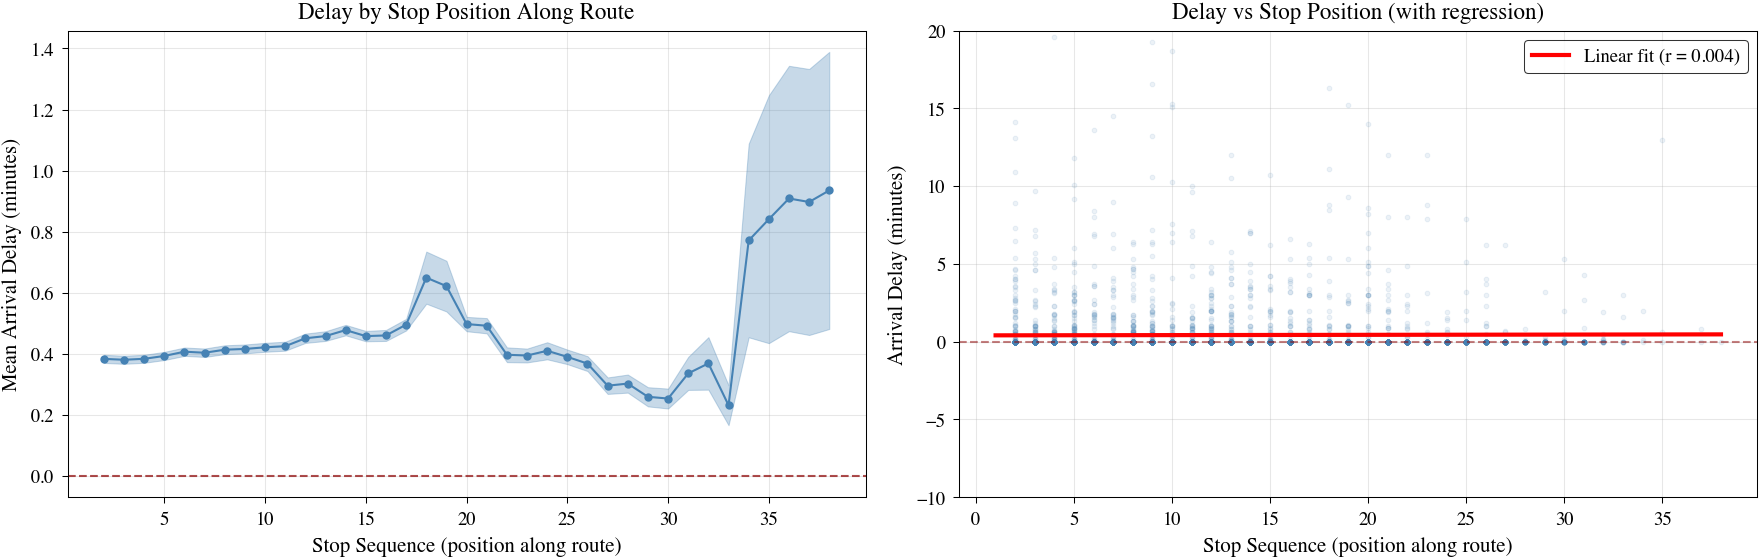


✓ Figure saved to plots/delay_accumulation_analysis.png

Conclusion: r = 0.0042 indicates NO correlation.
Delays do NOT systematically accumulate as buses progress through routes.


In [124]:
# =============================================================================
# DELAY ACCUMULATION ANALYSIS
# =============================================================================
# Question: Do delays accumulate as buses progress through their routes?
# Uses trip data with stop_sequence to analyze correlation between 
# route position and delay magnitude.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load trip data
trip_data = pd.read_parquet('outputs/all_trip_data.parquet')

print(f"Trip data loaded: {len(trip_data):,} rows")
print(f"Stop sequence range: {trip_data['stop_sequence'].min()} - {trip_data['stop_sequence'].max()}")

# Analyze: does delay increase with stop_sequence?
seq_stats = trip_data.groupby('stop_sequence')['arrival_delay_minutes'].agg(['mean', 'std', 'count'])
seq_stats = seq_stats[seq_stats['count'] >= 100]  # filter small samples
seq_stats['ci95'] = 1.96 * seq_stats['std'] / np.sqrt(seq_stats['count'])

# Correlation between stop_sequence and delay
valid = trip_data[trip_data['arrival_delay_minutes'].notna() & trip_data['stop_sequence'].notna()]
corr = valid['stop_sequence'].corr(valid['arrival_delay_minutes'])

print(f"\n=== DELAY BY STOP SEQUENCE ===")
print(f"Correlation (stop_sequence vs delay): r = {corr:.4f}")
print(f"\nSample of mean delays by stop position:")
for seq in [1, 5, 10, 15, 20, 25, 30]:
    if seq in seq_stats.index:
        row = seq_stats.loc[seq]
        print(f"  Stop {seq:2d}: mean = {row['mean']:.2f} min (n = {int(row['count']):,})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Mean delay by stop sequence
ax = axes[0]
ax.fill_between(seq_stats.index, 
                seq_stats['mean'] - seq_stats['ci95'],
                seq_stats['mean'] + seq_stats['ci95'],
                alpha=0.3, color='steelblue')
ax.plot(seq_stats.index, seq_stats['mean'], 'o-', color='steelblue', markersize=3)
ax.axhline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Stop Sequence (position along route)')
ax.set_ylabel('Mean Arrival Delay (minutes)')
ax.set_title('Delay by Stop Position Along Route', fontweight='bold')
ax.grid(alpha=0.3)

# Right: Scatter with regression line (sample for visibility)
ax = axes[1]
sample = valid.sample(min(5000, len(valid)), random_state=42)
ax.scatter(sample['stop_sequence'], sample['arrival_delay_minutes'], 
           alpha=0.1, s=5, color='steelblue')

# Add regression line
z = np.polyfit(valid['stop_sequence'], valid['arrival_delay_minutes'], 1)
p = np.poly1d(z)
x_line = np.linspace(1, seq_stats.index.max(), 100)
ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'Linear fit (r = {corr:.3f})')

ax.axhline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Stop Sequence (position along route)')
ax.set_ylabel('Arrival Delay (minutes)')
ax.set_title('Delay vs Stop Position (with regression)', fontweight='bold')
ax.set_ylim(-10, 20)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/delay_accumulation_analysis.png', dpi=150, bbox_inches='tight')
plt.savefig('plots/delay_accumulation_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to plots/delay_accumulation_analysis.png")
print(f"\nConclusion: r = {corr:.4f} indicates {'NO' if abs(corr) < 0.1 else 'weak' if abs(corr) < 0.3 else 'moderate'} correlation.")
print("Delays do NOT systematically accumulate as buses progress through routes.")

Grunddaten (EDA?)

In [125]:
# =========================
# Grunddaten: Mean, Median, CI95%
# Covers hypotheses via sensible groupings + produces a clean summary table.
# =========================

import numpy as np
import pandas as pd

df = all_departure_data.copy()

# ---- 1) Basic cleaning / preparation ----
# Ensure timestamps are datetime
for c in ["timestamp", "planned_time", "estimated_time", "weather_timestamp"]:
    if c in df.columns and not np.issubdtype(df[c].dtype, np.datetime64):
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Delay: keep only rows where delay_minutes exists
df = df[df["delay_minutes"].notna()].copy()

# Add useful time fields
df["date"] = df["timestamp"].dt.date
df["weekday"] = df["timestamp"].dt.day_name()
df["weekday_num"] = df["timestamp"].dt.weekday  # 0=Mon ... 6=Sun
df["is_weekend"] = df["weekday_num"].isin([5, 6])
df["month"] = df["timestamp"].dt.to_period("M").astype(str)

# Hour already exists, but ensure it’s numeric
df["hour"] = pd.to_numeric(df["hour"], errors="coerce")

# Delay variants (for Hypothesis 1 and “often late”)
df["is_late"] = df["delay_minutes"] > 0
df["delay_pos"] = df["delay_minutes"].where(df["delay_minutes"] > 0, np.nan)  # delay among late buses only

# Weather “bad weather” flags (covers Hypothesis 2)
#  - condition-based (categorical)
#  - precipitation/wind/cloud as numeric groupings
df["is_rainy"] = df["precipitation_mm"].fillna(0) > 0
df["precip_bin"] = pd.cut(
    df["precipitation_mm"].fillna(0),
    bins=[-0.001, 0, 0.5, 2, 10, np.inf],
    labels=["0", "0-0.5", "0.5-2", "2-10", "10+"]
)
df["wind_bin"] = pd.qcut(df["wind_speed_ms"].dropna(), q=4, duplicates="drop")
df["temp_bin"] = pd.qcut(df["temperature"].dropna(), q=4, duplicates="drop")
df["cloud_bin"] = pd.qcut(df["cloud_cover"].dropna(), q=4, duplicates="drop")

# Time-of-day bins (Hypothesis 4 & 6)
df["daypart"] = pd.cut(
    df["hour"],
    bins=[-0.5, 5.5, 9.5, 15.5, 19.5, 23.5],
    labels=["Nacht (0-5)", "Morgen-Peak (6-9)", "Mittag (10-15)", "Abend-Peak (16-19)", "Spät (20-23)"]
)

# Traffic proxy for Hypothesis 6: bus stop "busyness" = number of departures at stop
# (You can later combine with hour/daypart for "verkehrsreiche Tageszeit")
stop_counts = df["stop_name"].value_counts()
df["stop_busyness"] = df["stop_name"].map(stop_counts)
df["stop_busyness_bin"] = pd.qcut(df["stop_busyness"], q=4, duplicates="drop")

# ---- 2) Stats helpers: mean, median, CI95% (bootstrap, robust) ----
def bootstrap_ci(x, stat_fn=np.mean, n_boot=2000, ci=0.95, seed=42):
    """Return (low, high) bootstrap CI for a 1D array-like x."""
    x = pd.Series(x).dropna().values
    if len(x) < 2:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    stats = np.empty(n_boot, dtype=float)
    n = len(x)
    for i in range(n_boot):
        sample = rng.choice(x, size=n, replace=True)
        stats[i] = stat_fn(sample)
    alpha = 1 - ci
    return (np.quantile(stats, alpha / 2), np.quantile(stats, 1 - alpha / 2))

def summarize_series(x, label):
    """Compute n, mean, median, share late, and CI95% for mean (and median via bootstrap)."""
    x = pd.Series(x).dropna()
    n = len(x)
    if n == 0:
        return {
            "group": label,
            "n": 0,
            "mean": np.nan,
            "median": np.nan,
            "ci95_mean_low": np.nan,
            "ci95_mean_high": np.nan,
            "ci95_median_low": np.nan,
            "ci95_median_high": np.nan,
        }
    mean = x.mean()
    med = x.median()
    ci_mean = bootstrap_ci(x, stat_fn=np.mean)
    ci_med = bootstrap_ci(x, stat_fn=np.median)
    return {
        "group": label,
        "n": n,
        "mean": mean,
        "median": med,
        "ci95_mean_low": ci_mean[0],
        "ci95_mean_high": ci_mean[1],
        "ci95_median_low": ci_med[0],
        "ci95_median_high": ci_med[1],
    }

def group_summary(df_in, group_cols, value_col="delay_minutes", min_n=50, top_n=None):
    """
    Summarize delay stats by group_cols.
    - min_n filters small groups.
    - top_n keeps only top_n groups by frequency if group_cols is a single column.
    """
    d = df_in.copy()
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    if top_n is not None and len(group_cols) == 1:
        counts = d[group_cols[0]].value_counts()
        keep = counts.head(top_n).index
        d = d[d[group_cols[0]].isin(keep)]

    out = []
    for keys, g in d.groupby(group_cols, dropna=False):
        if not isinstance(keys, tuple):
            keys = (keys,)
        label = " | ".join([f"{col}={val}" for col, val in zip(group_cols, keys)])
        x = g[value_col]
        if x.notna().sum() >= min_n:
            out.append(summarize_series(x, label))
    return pd.DataFrame(out)

# ---- 3) Build summaries for hypotheses ----
tables = []

# H1: "oft" zu spät -> overall + share late + delay among all and among late only
overall_all = summarize_series(df["delay_minutes"], "OVERALL: delay_minutes (all with estimated_time)")
overall_late = summarize_series(df["delay_pos"], "OVERALL: delay_minutes (late only; delay>0)")

# Add late share and n for late
late_share = df["is_late"].mean()
n_total = df["delay_minutes"].notna().sum()
n_late = df["is_late"].sum()

overall_df = pd.DataFrame([overall_all, overall_late])
overall_df["late_share"] = [late_share, late_share]
overall_df["n_total"] = [n_total, n_total]
overall_df["n_late"] = [n_late, n_late]
tables.append(overall_df)

# H2: Weather impact
if "condition" in df.columns:
    tables.append(group_summary(df, "condition", "delay_minutes", min_n=100))
tables.append(group_summary(df, "is_rainy", "delay_minutes", min_n=200))
tables.append(group_summary(df, "precip_bin", "delay_minutes", min_n=200))
if "wind_bin" in df.columns:
    tables.append(group_summary(df, "wind_bin", "delay_minutes", min_n=200))
if "temp_bin" in df.columns:
    tables.append(group_summary(df, "temp_bin", "delay_minutes", min_n=200))
if "cloud_bin" in df.columns:
    tables.append(group_summary(df, "cloud_bin", "delay_minutes", min_n=200))

# H3: Stop dependence (top 25 stops, because otherwise too many)
tables.append(group_summary(df, "stop_name", "delay_minutes", min_n=200, top_n=25))

# H4: Delay changes over the day
tables.append(group_summary(df, "hour", "delay_minutes", min_n=200))
tables.append(group_summary(df, "daypart", "delay_minutes", min_n=200))

# H5: Delays getting larger over time (choose daily or monthly trend)
tables.append(group_summary(df, "date", "delay_minutes", min_n=100))   # daily (may be many rows)
tables.append(group_summary(df, "month", "delay_minutes", min_n=200))  # monthly trend

# H6: Local accumulation where traffic is higher (proxy: busyness quartiles, optionally by daypart)
tables.append(group_summary(df, "stop_busyness_bin", "delay_minutes", min_n=200))
tables.append(group_summary(df, ["stop_busyness_bin", "daypart"], "delay_minutes", min_n=200))

# H8: Weekend vs weekday (and by weekday name)
tables.append(group_summary(df, "is_weekend", "delay_minutes", min_n=200))
tables.append(group_summary(df, "weekday", "delay_minutes", min_n=200))

# Extra: by line and destination (often helpful for interpretation)
tables.append(group_summary(df, "line_name", "delay_minutes", min_n=200, top_n=20))
tables.append(group_summary(df, "destination", "delay_minutes", min_n=200, top_n=20))

# ---- 4) Combine into one tidy summary table ----
summary_df = pd.concat(tables, ignore_index=True)

# Add helpful sorting columns
summary_df["abs_mean"] = summary_df["mean"].abs()
summary_df = summary_df.sort_values(["n", "abs_mean"], ascending=[False, False]).drop(columns=["abs_mean"])

# ---- 5) Display + optional export ----
display(summary_df.head(30))
print(f"Total summary rows: {len(summary_df)}")

summary_df.to_csv("outputs/grunddaten_mean_median_ci95_summary.csv", index=False)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/572767097.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, g in d.groupby(group_cols, dropna=False):
/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/572767097.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for keys, g in d.groupby(group_cols, dropna=False):
/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/572767097.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

,group,n,mean,median,ci95_mean_low,ci95_mean_high,ci95_median_low,ci95_median_high,late_share,n_total,n_late
0,OVERALL: delay_minutes (all with estimated_time),191454,0.607172,0.0,0.596012,0.619502,0.0,0.0,0.18805,191454.0,36003.0
9,is_rainy=False,185203,0.593890,0.0,0.583113,0.605266,0.0,0.0,NaN,NaN,NaN
11,precip_bin=0,185203,0.593890,0.0,0.583113,0.605266,0.0,0.0,NaN,NaN,NaN
2,condition=dry,167209,0.611080,0.0,0.599092,0.623559,0.0,0.0,NaN,NaN,NaN
167,is_weekend=False,151791,0.674765,0.0,0.661434,0.688556,0.0,0.0,NaN,NaN,NaN
25,"cloud_bin=(75.0, 100.0]",137061,0.669229,0.0,0.654157,0.683939,0.0,0.0,NaN,NaN,NaN
147,month=2025-12,82482,0.692069,0.0,0.673867,0.711697,0.0,0.0,NaN,NaN,NaN
36,stop_name=Tübingen Neckarbrücke,77389,0.599132,0.0,0.581951,0.616989,0.0,0.0,NaN,NaN,NaN
151,"stop_busyness_bin=(61608.0, 77389.0]",77389,0.599132,0.0,0.581951,0.616989,0.0,0.0,NaN,NaN,NaN
66,daypart=Mittag (10-15),65534,0.513935,0.0,0.498044,0.531112,0.0,0.0,NaN,NaN,NaN


Total summary rows: 216


In [126]:
# =========================
# 1) Baseline: OVERALL (all)
# =========================

baseline = summary_df[
    summary_df["group"].str.contains("OVERALL: delay_minutes (all", regex=False)
].iloc[0]

overall_mean = float(baseline["mean"])
overall_low  = float(baseline["ci95_mean_low"])
overall_high = float(baseline["ci95_mean_high"])

print(f"OVERALL mean={overall_mean:.3f}, CI95=[{overall_low:.3f}, {overall_high:.3f}]")

# =========================
# 2) Interpretation columns
# =========================

dfi = summary_df.copy()

# difference to overall
dfi["delta_mean"] = dfi["mean"] - overall_mean

# CI non-overlap logic
dfi["clearly_higher"] = dfi["ci95_mean_low"]  > overall_high
dfi["clearly_lower"]  = dfi["ci95_mean_high"] < overall_low

dfi["direction"] = np.where(
    dfi["clearly_higher"], "higher",
    np.where(dfi["clearly_lower"], "lower", "overlap")
)

# show only clearly higher OR clearly lower groups
dfi["show"] = dfi["clearly_higher"] | dfi["clearly_lower"]

# =========================
# 3) Helper: mini tables
# =========================

def mini_table(title, pattern, top=10, min_n=200):
    t = dfi[dfi["group"].str.contains(pattern, regex=True, na=False)].copy()
    t = t[~t["group"].str.contains("OVERALL:", regex=True, na=False)]
    t = t[t["n"] >= min_n]
    t = t[t["show"]]

    # show strongest higher AND strongest lower
    higher = t.sort_values("delta_mean", ascending=False).head(top)
    lower  = t.sort_values("delta_mean", ascending=True).head(top)

    t = pd.concat([higher, lower]).drop_duplicates()

    out = t[
        ["group","n","mean","ci95_mean_low","ci95_mean_high","delta_mean","direction"]
    ].copy()

    for c in ["mean","ci95_mean_low","ci95_mean_high","delta_mean"]:
        out[c] = out[c].astype(float).round(3)

    print("\n" + title)
    display(out.reset_index(drop=True))

    return out.reset_index(drop=True)

# =========================
# 4) Per-hypothesis tables
# =========================

# H2: Weather
h2 = mini_table(
    "H2 Weather (clearly different from overall)",
    pattern=r"(?:condition=|is_rainy=|precip_bin=|wind_bin=|temp_bin=|cloud_bin=)",
    top=8,
    min_n=200
)

# H3: Stops
h3 = mini_table(
    "H3 Stops (clearly different from overall)",
    pattern=r"(?:stop_name=)",
    top=8,
    min_n=200
)

# H4: Time of day
h4 = mini_table(
    "H4 Time of day (clearly different from overall)",
    pattern=r"(?:hour=|daypart=)",
    top=8,
    min_n=200
)

# H5: Trend over time (months)
h5 = mini_table(
    "H5 Trend over time (months, descriptive)",
    pattern=r"(?:month=)",
    top=8,
    min_n=200
)

# H6: Busy-area proxy
h6 = mini_table(
    "H6 Busy-area proxy (clearly different from overall)",
    pattern=r"(?:stop_busyness_bin=)",
    top=8,
    min_n=200
)

# H8: Weekend
h8 = mini_table(
    "H8 Weekend vs weekday (clearly different from overall)",
    pattern=r"(?:is_weekend=|weekday=)",
    top=8,
    min_n=200
)

# =========================
# 5) One slide-ready summary
# =========================

top = dfi[dfi["show"]].copy()
top = top[~top["group"].str.contains("OVERALL:", regex=True, na=False)]
top = top.sort_values("delta_mean", ascending=False).head(15)

top_out = top[
    ["group","n","mean","ci95_mean_low","ci95_mean_high","delta_mean","direction"]
].copy()

for c in ["mean","ci95_mean_low","ci95_mean_high","delta_mean"]:
    top_out[c] = top_out[c].astype(float).round(3)

print("\nTop findings (all groupings):")
display(top_out.reset_index(drop=True))

OVERALL mean=0.607, CI95=[0.596, 0.620]

H2 Weather (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,precip_bin=2-10,234,1.805,1.371,2.274,1.198,higher
1,precip_bin=0.5-2,2459,1.349,1.123,1.582,0.742,higher
2,condition=snow,2546,1.066,0.845,1.302,0.458,higher
3,is_rainy=True,6251,1.001,0.899,1.107,0.394,higher
4,"temp_bin=(6.2, 19.1]",47818,0.842,0.816,0.868,0.235,higher
5,"temp_bin=(2.8, 6.2]",46787,0.718,0.696,0.741,0.111,higher
6,precip_bin=0-0.5,3558,0.707,0.631,0.786,0.100,higher
7,"cloud_bin=(75.0, 100.0]",137061,0.669,0.654,0.684,0.062,higher
8,condition=hail,739,0.201,0.147,0.261,-0.406,lower
9,condition=sleet,648,0.230,0.156,0.314,-0.377,lower



H3 Stops (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,stop_name=Tübingen Freibad,7378,1.353,1.282,1.424,0.746,higher
1,stop_name=Tübingen Mühlstraße,2063,0.878,0.768,0.996,0.270,higher
2,stop_name=Tübingen Poststraße,16493,0.843,0.795,0.891,0.235,higher
3,stop_name=Tübingen Hegelstraße,7380,0.786,0.708,0.869,0.178,higher
4,stop_name=Tübingen Hauptbahnhof,61608,0.472,0.454,0.490,-0.135,lower
5,stop_name=Tübingen Ernst-Bloch-Straße,1886,0.444,0.337,0.566,-0.163,lower
6,stop_name=Tübingen Biesingerstraße,1894,0.441,0.336,0.564,-0.166,lower
7,stop_name=Tübingen Neckarhalde,1894,0.440,0.335,0.563,-0.167,lower
8,stop_name=Tübingen Kelternplatz,2962,0.384,0.323,0.448,-0.223,lower
9,stop_name=Tübingen Hermann Hepper Halle,3166,0.427,0.367,0.490,-0.180,lower



H4 Time of day (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,hour=17,11912,1.332,1.268,1.403,0.725,higher
1,hour=3,973,1.313,1.071,1.566,0.706,higher
2,"stop_busyness_bin=(0.999, 16493.0] | daypart=A...",12745,1.235,1.177,1.298,0.628,higher
3,"stop_busyness_bin=(0.999, 16493.0] | daypart=N...",1360,1.103,0.883,1.337,0.496,higher
4,hour=1,1110,1.096,0.842,1.378,0.488,higher
5,hour=16,13990,1.061,1.005,1.120,0.453,higher
6,daypart=Abend-Peak (16-19),47212,0.986,0.958,1.016,0.379,higher
7,"stop_busyness_bin=(61608.0, 77389.0] | daypart...",19276,0.963,0.918,1.009,0.356,higher
8,hour=23,5621,0.169,0.148,0.192,-0.438,lower
9,hour=6,10957,0.199,0.174,0.228,-0.409,lower



H5 Trend over time (months, descriptive)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,month=2025-12,82482,0.692,0.674,0.712,0.085,higher
1,month=2025-11,47150,0.684,0.661,0.707,0.076,higher
2,month=2026-01,61822,0.436,0.416,0.455,-0.172,lower



H6 Busy-area proxy (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,"stop_busyness_bin=(0.999, 16493.0] | daypart=A...",12745,1.235,1.177,1.298,0.628,higher
1,"stop_busyness_bin=(0.999, 16493.0] | daypart=N...",1360,1.103,0.883,1.337,0.496,higher
2,"stop_busyness_bin=(61608.0, 77389.0] | daypart...",19276,0.963,0.918,1.009,0.356,higher
3,"stop_busyness_bin=(16493.0, 61608.0] | daypart...",15191,0.806,0.757,0.855,0.199,higher
4,"stop_busyness_bin=(0.999, 16493.0]",52457,0.778,0.755,0.803,0.171,higher
5,"stop_busyness_bin=(0.999, 16493.0] | daypart=M...",17320,0.706,0.672,0.739,0.098,higher
6,"stop_busyness_bin=(61608.0, 77389.0] | daypart...",27128,0.520,0.497,0.544,-0.087,lower
7,"stop_busyness_bin=(16493.0, 61608.0]",61608,0.472,0.454,0.490,-0.135,lower
8,"stop_busyness_bin=(16493.0, 61608.0] | daypart...",8068,0.274,0.226,0.332,-0.333,lower
9,"stop_busyness_bin=(61608.0, 77389.0] | daypart...",9918,0.328,0.278,0.383,-0.279,lower



H8 Weekend vs weekday (clearly different from overall)


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,weekday=Thursday,30738,0.763,0.727,0.801,0.156,higher
1,weekday=Tuesday,28839,0.728,0.697,0.760,0.121,higher
2,is_weekend=False,151791,0.675,0.661,0.689,0.068,higher
3,weekday=Monday,27594,0.673,0.642,0.705,0.066,higher
4,weekday=Wednesday,31697,0.668,0.641,0.697,0.061,higher
5,weekday=Friday,32923,0.553,0.530,0.577,-0.054,lower
6,weekday=Saturday,22593,0.355,0.333,0.379,-0.252,lower
7,is_weekend=True,39663,0.348,0.329,0.370,-0.259,lower
8,weekday=Sunday,17070,0.339,0.302,0.378,-0.268,lower



Top findings (all groupings):


,group,n,mean,ci95_mean_low,ci95_mean_high,delta_mean,direction
0,line_name=18,8043,2.093,2.024,2.162,1.486,higher
1,date=2025-12-08,2446,1.983,1.801,2.189,1.375,higher
2,precip_bin=2-10,234,1.805,1.371,2.274,1.198,higher
3,date=2025-12-11,3216,1.714,1.538,1.906,1.107,higher
4,date=2025-12-02,3936,1.432,1.315,1.557,0.825,higher
5,stop_name=Tübingen Freibad,7378,1.353,1.282,1.424,0.746,higher
6,precip_bin=0.5-2,2459,1.349,1.123,1.582,0.742,higher
7,hour=17,11912,1.332,1.268,1.403,0.725,higher
8,hour=3,973,1.313,1.071,1.566,0.706,higher
9,date=2026-01-25,1593,1.281,0.948,1.639,0.674,higher


## Network Graph

In [127]:
all_trip_data = download_and_combine_data(trip_files)
print(f"Loaded {len(all_trip_data)} trip-call rows from {len(trip_files)} files.")

Processing 1550 files in parallel (max_workers=20)...
Processed 100/1550 files...
Processed 200/1550 files...
Processed 300/1550 files...
Processed 400/1550 files...
Processed 500/1550 files...
Processed 600/1550 files...
Processed 700/1550 files...
Processed 800/1550 files...
Processed 900/1550 files...
Processed 1000/1550 files...
Processed 1100/1550 files...
Processed 1200/1550 files...
Processed 1300/1550 files...
Processed 1400/1550 files...
Processed 1500/1550 files...
Processed 1550/1550 files...

Combined 1550 files into DataFrame with 2015702 rows.
Date range: 2025-11-11 17:00:32 to 2026-01-26 09:00:33
Loaded 2015702 trip-call rows from 1550 files.


In [128]:
# =============================================================================
# TRIP DATA FILTERING (uses same controls as departure data)
# =============================================================================
# Apply the same date filter to trip data for consistency

if SPLIT_BY_SCHEDULE_CHANGE:
    if USE_DATA_BEFORE_CHANGE:
        date_filter = all_trip_data['timestamp'] < SCHEDULE_CHANGE_DATE
    else:
        date_filter = all_trip_data['timestamp'] >= SCHEDULE_CHANGE_DATE

    all_trip_data = all_trip_data[date_filter].copy()
    print(f"✓ Filtered trip data: {period_label}")
    print(f"  Rows: {len(all_trip_data):,}")
    print(f"  Date range: {all_trip_data['timestamp'].min()} to {all_trip_data['timestamp'].max()}")
else:
    print("✓ Using ALL trip data (no date filtering)")
    print(f"  Rows: {len(all_trip_data):,}")
    print(f"  Date range: {all_trip_data['timestamp'].min()} to {all_trip_data['timestamp'].max()}")

# --- Apply train filtering to trip data ---
if FILTER_TRAINS and 'line_name' in all_trip_data.columns:
    train_mask = all_trip_data['line_name'].apply(is_train_line)
    n_trains = train_mask.sum()
    
    if n_trains > 0:
        train_lines = all_trip_data[train_mask]['line_name'].unique()
        print(f"\n⚠ Found {n_trains:,} train trip records to filter out")
        print(f"  Train lines removed: {sorted(train_lines)}")
        
        all_trip_data = all_trip_data[~train_mask].copy()
        print(f"✓ Removed {n_trains:,} train trip records (keeping buses only)")
        print(f"  Rows after filtering: {len(all_trip_data):,}")
    else:
        print("\n✓ No train lines found in trip data")
elif FILTER_TRAINS:
    print("\n⚠ No 'line_name' column in trip data - cannot filter trains")
else:
    print("\n✓ Train filtering disabled for trip data")

# --- Apply outlier filtering to trip data ---
if FILTER_DELAY_OUTLIERS and 'departure_delay_minutes' in all_trip_data.columns:
    outlier_mask = all_trip_data['departure_delay_minutes'] > DELAY_MAX_THRESHOLD
    n_outliers = outlier_mask.sum()

    if n_outliers > 0:
        all_trip_data = all_trip_data[~outlier_mask].copy()
        print(f"✓ Removed {n_outliers:,} trip outliers (delay > {DELAY_MAX_THRESHOLD} min)")
        print(f"  Rows after filtering: {len(all_trip_data):,}")

# --- Summary ---
print(f"\n{'='*60}")
print(f"FINAL TRIP DATA: {len(all_trip_data):,} rows")
if 'line_name' in all_trip_data.columns:
    print(f"Unique lines: {all_trip_data['line_name'].nunique()}")
print(f"{'='*60}")

✓ Using ALL trip data (no date filtering)
  Rows: 2,015,702
  Date range: 2025-11-11 17:00:32 to 2026-01-26 09:00:33

⚠ Found 142,945 train trip records to filter out
  Train lines removed: ['MEX12', 'MEX18', 'RB 6', 'RB 63', 'RB 66', 'RB 74', 'RB63', 'RB63E', 'RE 6', 'RE6', 'S1']
✓ Removed 142,945 train trip records (keeping buses only)
  Rows after filtering: 1,872,757
✓ Removed 722 trip outliers (delay > 90 min)
  Rows after filtering: 1,872,035

FINAL TRIP DATA: 1,872,035 rows
Unique lines: 68


In [129]:
# Print data
display(all_trip_data.head(10))

,phase,stop_point_ref,stop_name,stop_sequence,platform,arrival_planned,arrival_estimated,departure_planned,departure_estimated,arrival_delay_minutes,departure_delay_minutes,journey_ref,operating_day_ref,line_name,destination,timestamp
0,onward,de:08416:11000:13:M,Tübingen Hauptbahnhof,1,Bstg. M,NaN,NaN,2025-11-12 04:12:00,2025-11-12 04:12:00,NaN,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15
1,onward,de:08416:10520:0:3,Tübingen Wilhelmstraße,2,NaN,2025-11-12 04:14:00,2025-11-12 04:14:00,2025-11-12 04:14:00,2025-11-12 04:14:00,0.0,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15
2,onward,de:08416:10503:0:1,Tübingen Uni / Neue Aula,3,NaN,2025-11-12 04:15:00,2025-11-12 04:15:00,2025-11-12 04:15:00,2025-11-12 04:15:00,0.0,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15
3,onward,de:08416:10505:0:1,Tübingen Pauline-Krone-Heim,4,NaN,2025-11-12 04:17:00,2025-11-12 04:17:00,2025-11-12 04:17:00,2025-11-12 04:17:00,0.0,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15
4,onward,de:08416:10305:0:1,Tübingen Stuttgarter Str.,5,NaN,2025-11-12 04:19:00,2025-11-12 04:19:00,2025-11-12 04:19:00,2025-11-12 04:19:00,0.0,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15
5,onward,de:08416:16350:0:1,Bebenhausen Waldhorn,6,NaN,2025-11-12 04:24:00,2025-11-12 04:24:00,2025-11-12 04:24:00,2025-11-12 04:24:00,0.0,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15
6,onward,de:08115:7036:0:4,Weil i. S. Kälberstelle,7,NaN,2025-11-12 04:29:00,2025-11-12 04:29:00,2025-11-12 04:29:00,2025-11-12 04:29:00,0.0,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15
7,onward,de:08416:6352:0:1,Dettenhausen Tübinger Straße,8,NaN,2025-11-12 04:32:00,2025-11-12 04:32:00,2025-11-12 04:32:00,2025-11-12 04:32:00,0.0,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15
8,onward,de:08416:6353:0:1,Dettenhausen Alte Post,9,NaN,2025-11-12 04:33:00,2025-11-12 04:33:00,2025-11-12 04:33:00,2025-11-12 04:33:00,0.0,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15
9,onward,de:08115:2815:0:4,Waldenbuch Bonholz,10,NaN,2025-11-12 04:38:00,2025-11-12 04:38:00,2025-11-12 04:38:00,2025-11-12 04:38:00,0.0,0.0,vvs:31X82::R:j25:1,2025-11-12,X82,Echterdingen Flughafen/Messe (SAB),2025-11-12 03:00:15


Join coordinates into trip data and fetch missing from TRIAS api

In [130]:
from trias import TriasClient

# =============================================================================
# STEP 1: Discover stops via multi-center TRIAS queries
# =============================================================================
# The TRIAS API returns ~14 stops per request. By querying from multiple centers
# (existing stops with known coordinates), we can discover more stops.

trias_client = TriasClient(requestor_ref="SeBaSTiaN_BoeHLeR")

# Get initial centers from departure data
initial_centers = (
    all_departure_data
    .dropna(subset=['latitude', 'longitude'])
    .groupby('stop_id', as_index=False)
    .agg({'latitude': 'first', 'longitude': 'first', 'stop_name': 'first'})
    .head(20)  # Start with 20 centers
)

print(f"Discovering stops using {len(initial_centers)} initial centers...")

discovered_stops = {}  # stop_id -> {stop_id, stop_name, latitude, longitude}
processed_centers = set()

def discover_from_center(lat, lon, radius_km=3):
    """Fetch stops from TRIAS API using given center coordinates."""
    try:
        stops = trias_client.fetch_stops(center=(lat, lon), radius_km=radius_km, max_results=200)
        return stops
    except Exception:
        return pd.DataFrame()

# Initial discovery from departure data centers
for _, row in initial_centers.iterrows():
    stops = discover_from_center(row['latitude'], row['longitude'])
    for _, s in stops.iterrows():
        if s['stop_id'] not in discovered_stops:
            discovered_stops[s['stop_id']] = {
                'stop_id': s['stop_id'],
                'stop_name': s.get('stop_name'),
                'latitude': s.get('latitude'),
                'longitude': s.get('longitude'),
            }
    processed_centers.add(row['stop_id'])

print(f"After initial discovery: {len(discovered_stops)} stops")

# Iterative expansion: use newly discovered stops as centers
for iteration in range(3):
    new_centers = [
        s for sid, s in discovered_stops.items()
        if sid not in processed_centers
        and pd.notna(s.get('latitude'))
        and pd.notna(s.get('longitude'))
    ]

    if not new_centers:
        break

    new_discoveries = 0
    for stop in new_centers[:15]:  # Limit API calls per iteration
        processed_centers.add(stop['stop_id'])
        stops = discover_from_center(stop['latitude'], stop['longitude'])
        for _, s in stops.iterrows():
            if s['stop_id'] not in discovered_stops:
                discovered_stops[s['stop_id']] = {
                    'stop_id': s['stop_id'],
                    'stop_name': s.get('stop_name'),
                    'latitude': s.get('latitude'),
                    'longitude': s.get('longitude'),
                }
                new_discoveries += 1

    print(f"Iteration {iteration + 1}: +{new_discoveries} stops, total: {len(discovered_stops)}")
    if new_discoveries == 0:
        break

# Create DataFrame of discovered stops
trias_stops_df = pd.DataFrame(discovered_stops.values())
print(f"\nTotal discovered stops with coordinates: {len(trias_stops_df)}")

# =============================================================================
# STEP 2: Join coordinates from multiple sources onto trip data
# =============================================================================

# Source 1: Departure data coordinates (by stop_point_ref)
dep_coords_ref = (
    all_departure_data
    .dropna(subset=['latitude', 'longitude'])
    .groupby('stop_point_ref', as_index=False)[['latitude', 'longitude']]
    .mean()
)

# Source 2: Departure data coordinates (by stop_name as fallback)
dep_coords_name = (
    all_departure_data
    .dropna(subset=['latitude', 'longitude'])
    .groupby('stop_name', as_index=False)[['latitude', 'longitude']]
    .mean()
)

# Source 3: TRIAS discovered stops (by stop_id - base ID without platform suffix)
trias_coords = (
    trias_stops_df
    .dropna(subset=['latitude', 'longitude'])
    .rename(columns={'latitude': 'lat_trias', 'longitude': 'lon_trias'})
)

# Drop any existing coordinate columns
for col in ['latitude', 'longitude']:
    if col in all_trip_data.columns:
        all_trip_data = all_trip_data.drop(columns=[col])

# Extract base stop_id from stop_point_ref for TRIAS matching
# stop_point_ref like "de:08416:10044:0:1" -> stop_id "de:08416:10044"
all_trip_data['stop_id_base'] = all_trip_data['stop_point_ref'].str.extract(r'^(de:\d+:\d+)')[0]

# Join 1: From departure data by stop_point_ref
all_trip_data = all_trip_data.merge(dep_coords_ref, on='stop_point_ref', how='left')

# Join 2: From TRIAS by base stop_id
all_trip_data = all_trip_data.merge(
    trias_coords[['stop_id', 'lat_trias', 'lon_trias']],
    left_on='stop_id_base',
    right_on='stop_id',
    how='left'
)

# Fill missing coords from TRIAS
all_trip_data['latitude'] = all_trip_data['latitude'].fillna(all_trip_data['lat_trias'])
all_trip_data['longitude'] = all_trip_data['longitude'].fillna(all_trip_data['lon_trias'])

# Join 3: Fallback by stop_name
missing_mask = all_trip_data['latitude'].isna() | all_trip_data['longitude'].isna()
if missing_mask.any():
    fallback = (
        all_trip_data[missing_mask]
        .merge(dep_coords_name, on='stop_name', how='left', suffixes=('', '_fb'))
    )
    all_trip_data.loc[missing_mask, 'latitude'] = fallback['latitude_fb'].values
    all_trip_data.loc[missing_mask, 'longitude'] = fallback['longitude_fb'].values

# Clean up temporary columns
all_trip_data = all_trip_data.drop(columns=['stop_id_base', 'stop_id', 'lat_trias', 'lon_trias'], errors='ignore')

# Report coverage
stops_total = all_trip_data['stop_point_ref'].nunique()
stops_with_coords = all_trip_data[
    all_trip_data['latitude'].notna() & all_trip_data['longitude'].notna()
]['stop_point_ref'].nunique()

print(f"\nCoordinate coverage: {stops_with_coords}/{stops_total} unique stops ({100*stops_with_coords/stops_total:.1f}%)")

Discovering stops using 20 initial centers...
After initial discovery: 95 stops
Iteration 1: +26 stops, total: 121
Iteration 2: +21 stops, total: 142
Iteration 3: +12 stops, total: 154

Total discovered stops with coordinates: 154

Coordinate coverage: 224/950 unique stops (23.6%)


In [131]:
# Export trip data for per-line network graph generation
# This parquet file is used by generate_per_line_graphs.py
all_trip_data.to_parquet("outputs/all_trip_data.parquet", index=False)
print(f"Exported {len(all_trip_data):,} trip records to outputs/all_trip_data.parquet")

Exported 1,872,035 trip records to outputs/all_trip_data.parquet


# Academic Hypothesis Plots

Publication-quality figures for the Data Literacy course paper. Each plot addresses a specific hypothesis from the meeting notes, following course guidelines:
- **Estimators + Confidence Intervals** over p-values
- **DKW bands** for ECDFs
- **Bootstrap CIs** for medians and percentiles
- Clear annotations with interpretable metrics

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/292226604.py:88: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


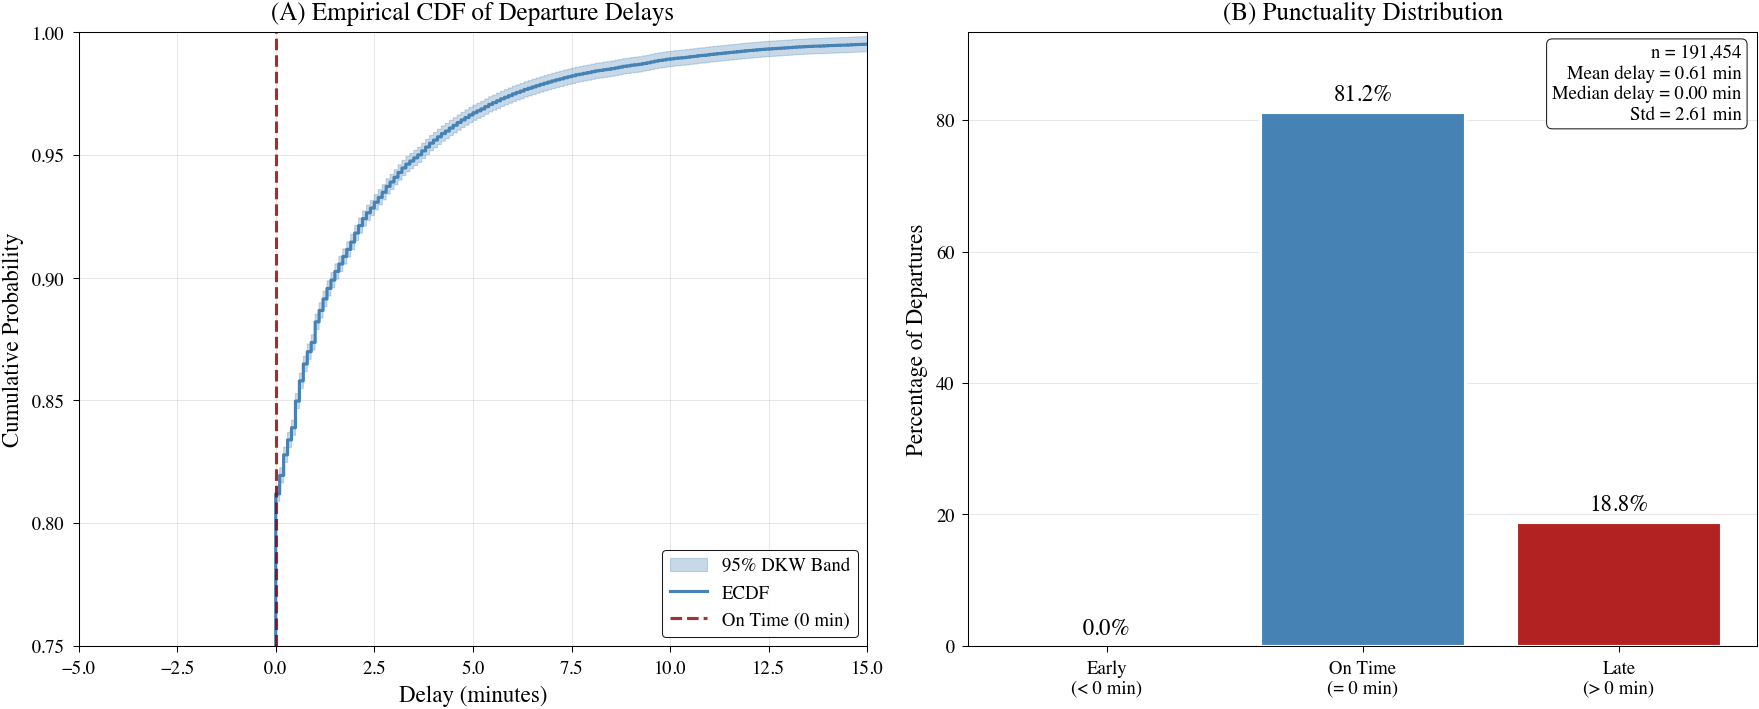


HYPOTHESIS 1 SUMMARY: Are Tübingen buses often late?
  Total observations: 191,454
  Late rate (delay > 0): 18.8%
  On-time rate (delay = 0): 81.2%
  Early rate (delay < 0): 0.0%
  Mean delay: 0.61 min
  Median delay: 0.00 min


In [132]:
# =============================================================================
# HYPOTHESIS 1: "Tübinger Busse sind oft zu spät"
# Figure: ECDF with DKW confidence bands + key metrics annotated
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Academic style
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Get delay data
delays = all_departure_data['delay_minutes'].dropna().values

# --- Panel A: ECDF with DKW confidence bands ---
ax = axes[0]

# Sort delays for ECDF
x_sorted = np.sort(delays)
n = len(x_sorted)
ecdf_y = np.arange(1, n + 1) / n

# DKW confidence bands (95%)
alpha = 0.05
epsilon = np.sqrt(np.log(2 / alpha) / (2 * n))
lower = np.clip(ecdf_y - epsilon, 0, 1)
upper = np.clip(ecdf_y + epsilon, 0, 1)

# Plot ECDF with bands
ax.fill_between(x_sorted, lower, upper, alpha=0.3, color='steelblue', label='95% DKW Band')
ax.step(x_sorted, ecdf_y, where='post', color='steelblue', linewidth=1.5, label='ECDF')

# Mark key thresholds
ax.axvline(0, color='darkred', linestyle='--', linewidth=1.5, alpha=0.8, label='On Time (0 min)')
ax.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.6)

# Annotate late rate
late_rate = np.mean(delays > 0)
on_time_rate = np.mean(delays == 0)
early_rate = np.mean(delays < 0)

ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Cumulative Probability')
ax.set_title('(A) Empirical CDF of Departure Delays', fontweight='bold')
ax.set_xlim(-5, 15)
ax.set_ylim(0.75, 1.0)
ax.legend(loc='lower right', framealpha=0.9)
ax.grid(alpha=0.3)

# --- Panel B: Summary statistics ---
ax = axes[1]

# Create summary bar chart
categories = ['Early\n(< 0 min)', 'On Time\n(= 0 min)', 'Late\n(> 0 min)']
values = [early_rate * 100, on_time_rate * 100, late_rate * 100]
colors = ['forestgreen', 'steelblue', 'firebrick']

bars = ax.bar(categories, values, color=colors, edgecolor='white', linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Percentage of Departures')
ax.set_title('(B) Punctuality Distribution', fontweight='bold')
ax.set_ylim(0, max(values) * 1.15)
ax.grid(axis='y', alpha=0.3)

# Add summary stats text box
stats_text = (f'n = {n:,}\n'
              f'Mean delay = {np.mean(delays):.2f} min\n'
              f'Median delay = {np.median(delays):.2f} min\n'
              f'Std = {np.std(delays):.2f} min')
ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.savefig('plots/fig1_hypothesis1_delay_ecdf.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig1_hypothesis1_delay_ecdf.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 1 SUMMARY: Are Tübingen buses often late?")
print("="*70)
print(f"  Total observations: {n:,}")
print(f"  Late rate (delay > 0): {100*late_rate:.1f}%")
print(f"  On-time rate (delay = 0): {100*on_time_rate:.1f}%")
print(f"  Early rate (delay < 0): {100*early_rate:.1f}%")
print(f"  Mean delay: {np.mean(delays):.2f} min")
print(f"  Median delay: {np.median(delays):.2f} min")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/3876374736.py:88: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


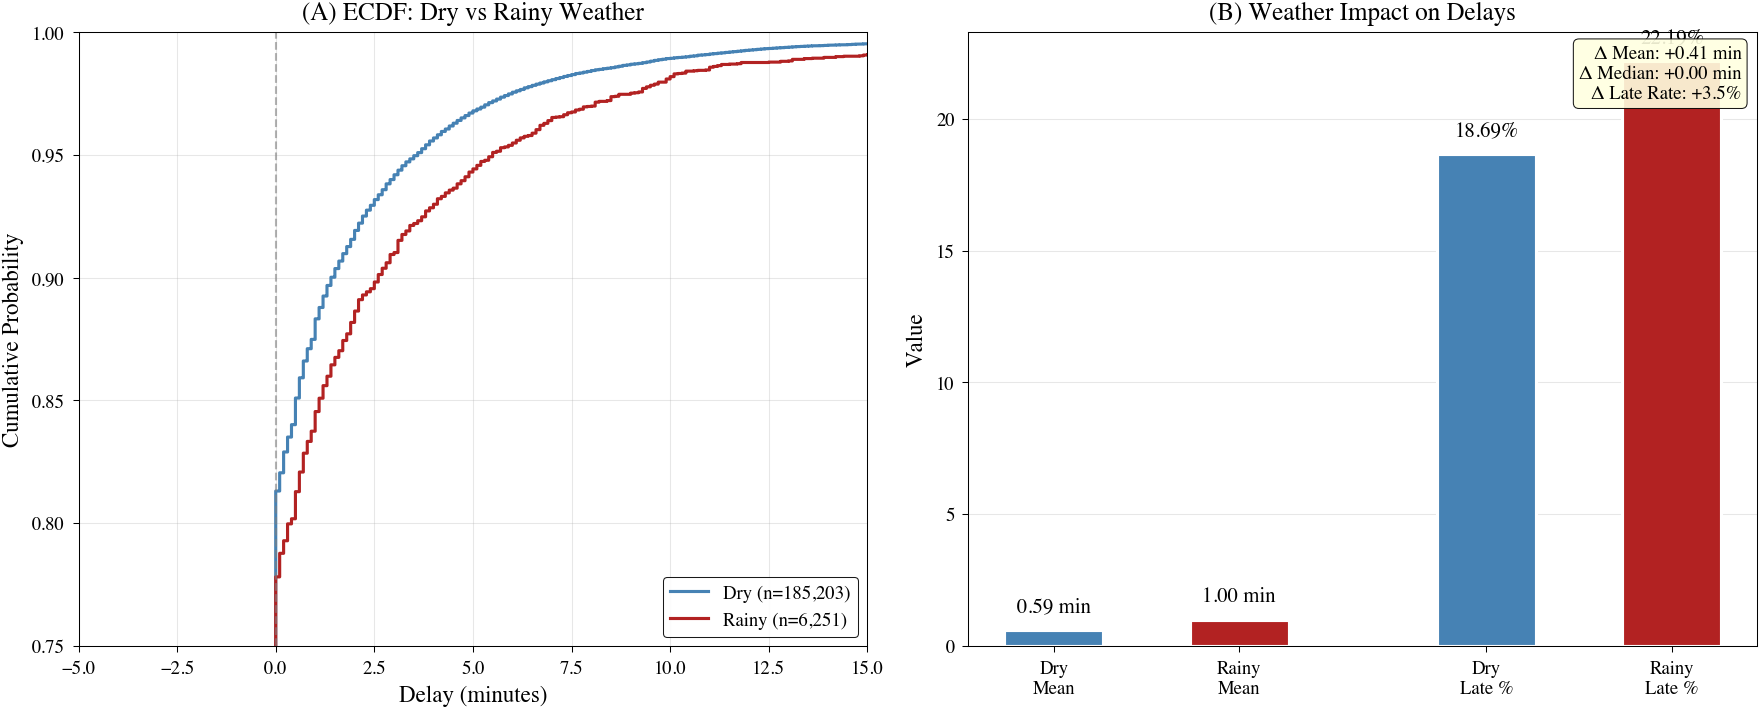


HYPOTHESIS 2 SUMMARY: Are delays larger in bad weather?
  Dry weather:  n=185,203, mean=0.59 min, median=0.00 min, late=18.7%
  Rainy weather: n=6,251, mean=1.00 min, median=0.00 min, late=22.2%
  Difference: Δmean=+0.41 min, Δmedian=+0.00 min, Δlate=+3.5%


In [133]:
# =============================================================================
# HYPOTHESIS 2: "Verspätung ist größer bei schlechtem Wetter"
# Figure: ECDF comparison dry vs rainy with DKW bands + effect size
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define weather groups: dry vs rainy (precipitation > 0)
df = all_departure_data.copy()
df['is_rainy'] = df['precipitation_mm'] > 0

delays_dry = df.loc[~df['is_rainy'], 'delay_minutes'].dropna().values
delays_rainy = df.loc[df['is_rainy'], 'delay_minutes'].dropna().values

# --- Panel A: ECDF comparison ---
ax = axes[0]

for delays, label, color in [(delays_dry, 'Dry', 'steelblue'),
                              (delays_rainy, 'Rainy', 'firebrick')]:
    x_sorted = np.sort(delays)
    n = len(x_sorted)
    ecdf_y = np.arange(1, n + 1) / n
    ax.step(x_sorted, ecdf_y, where='post', color=color, linewidth=1.5, label=f'{label} (n={n:,})')

ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.6)
ax.set_xlabel('Delay (minutes)')
ax.set_ylabel('Cumulative Probability')
ax.set_title('(A) ECDF: Dry vs Rainy Weather', fontweight='bold')
ax.set_xlim(-5, 15)
ax.set_ylim(0.75, 1.0)
ax.legend(loc='lower right', framealpha=0.9)
ax.grid(alpha=0.3)

# --- Panel B: Summary comparison (using MEAN since median is often 0) ---
ax = axes[1]

# Calculate statistics
stats = {
    'Dry': {
        'mean': np.mean(delays_dry),
        'median': np.median(delays_dry),
        'late_rate': np.mean(delays_dry > 0),
        'n': len(delays_dry)
    },
    'Rainy': {
        'mean': np.mean(delays_rainy),
        'median': np.median(delays_rainy),
        'late_rate': np.mean(delays_rainy > 0),
        'n': len(delays_rainy)
    }
}

# Bar chart comparing mean delay and late rate
x_pos = np.array([0, 1.5, 3.5, 5])
labels = ['Dry\nMean', 'Rainy\nMean', 'Dry\nLate %', 'Rainy\nLate %']
values = [stats['Dry']['mean'], stats['Rainy']['mean'],
          stats['Dry']['late_rate'] * 100, stats['Rainy']['late_rate'] * 100]
colors = ['steelblue', 'firebrick', 'steelblue', 'firebrick']

bars = ax.bar(x_pos, values, color=colors, edgecolor='white', linewidth=1.5, width=0.8)

# Add value labels
for bar, val, pos in zip(bars, values, x_pos):
    unit = ' min' if pos < 2 else '%'
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.2f}{unit}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel('Value')
ax.set_title('(B) Weather Impact on Delays', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add effect size annotation
diff_mean = stats['Rainy']['mean'] - stats['Dry']['mean']
diff_median = stats['Rainy']['median'] - stats['Dry']['median']
diff_late = (stats['Rainy']['late_rate'] - stats['Dry']['late_rate']) * 100

effect_text = (f"Δ Mean: {diff_mean:+.2f} min\n"
               f"Δ Median: {diff_median:+.2f} min\n"
               f"Δ Late Rate: {diff_late:+.1f}%")
ax.text(0.98, 0.98, effect_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig('plots/fig2_hypothesis2_weather.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig2_hypothesis2_weather.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 2 SUMMARY: Are delays larger in bad weather?")
print("="*70)
print(f"  Dry weather:  n={stats['Dry']['n']:,}, mean={stats['Dry']['mean']:.2f} min, "
      f"median={stats['Dry']['median']:.2f} min, late={100*stats['Dry']['late_rate']:.1f}%")
print(f"  Rainy weather: n={stats['Rainy']['n']:,}, mean={stats['Rainy']['mean']:.2f} min, "
      f"median={stats['Rainy']['median']:.2f} min, late={100*stats['Rainy']['late_rate']:.1f}%")
print(f"  Difference: Δmean={diff_mean:+.2f} min, Δmedian={diff_median:+.2f} min, Δlate={diff_late:+.1f}%")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/3778000027.py:112: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


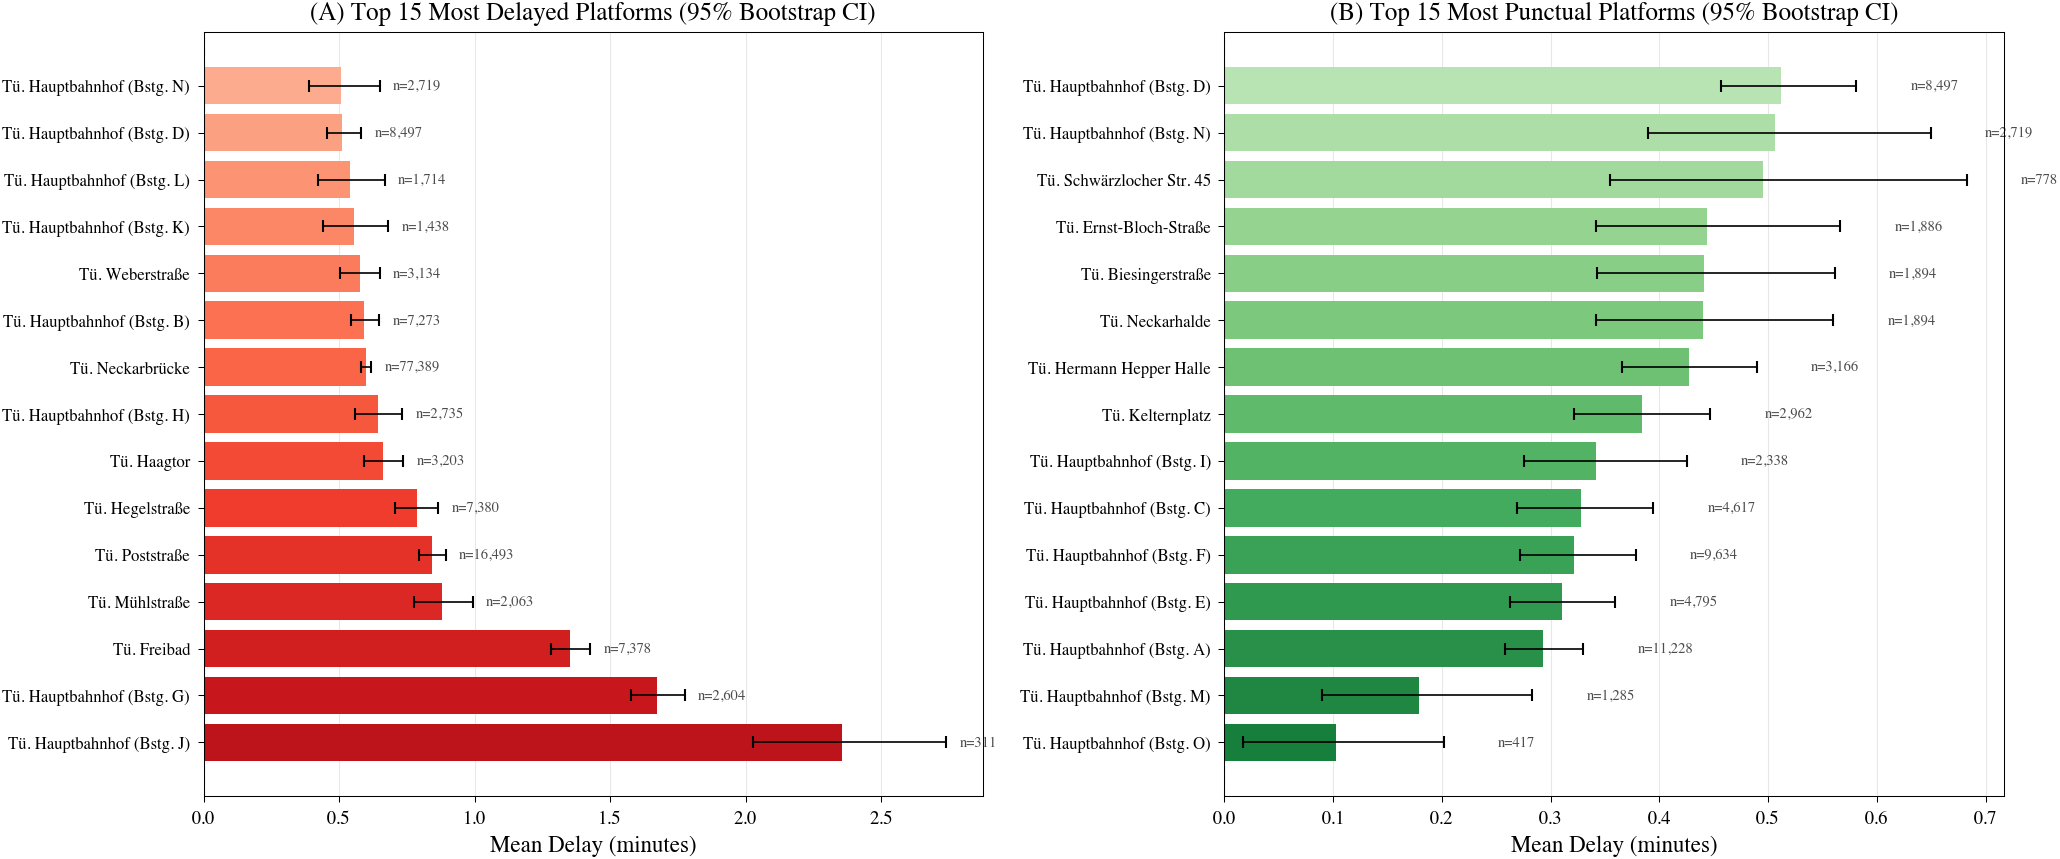


HYPOTHESIS 3 SUMMARY: Do delays depend on stops?
  Granularity: Platform-level
  Platforms analyzed (n≥100): 28
  Range of mean delays: 0.10 to 2.36 min

  Top 5 most delayed platforms:
    - Tü. Hauptbahnhof (Bstg. J): mean=2.36 min, late=56.9%, n=311
    - Tü. Hauptbahnhof (Bstg. G): mean=1.67 min, late=49.4%, n=2,604
    - Tü. Freibad: mean=1.35 min, late=37.4%, n=7,378
    - Tü. Mühlstraße: mean=0.88 min, late=41.8%, n=2,063
    - Tü. Poststraße: mean=0.84 min, late=29.9%, n=16,493

  Top 5 most punctual platforms:
    - Tü. Hauptbahnhof (Bstg. F): mean=0.32 min, late=10.4%, n=9,634
    - Tü. Hauptbahnhof (Bstg. E): mean=0.31 min, late=9.7%, n=4,795
    - Tü. Hauptbahnhof (Bstg. A): mean=0.29 min, late=7.9%, n=11,228
    - Tü. Hauptbahnhof (Bstg. M): mean=0.18 min, late=1.7%, n=1,285
    - Tü. Hauptbahnhof (Bstg. O): mean=0.10 min, late=1.7%, n=417


In [134]:
# =============================================================================
# HYPOTHESIS 3: "Die Verspätungen hängen von den Haltestellen ab"
# Figure: Top/Bottom stops by mean delay with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Toggle between platform-level granularity and stop-level aggregation
USE_PLATFORM_GRANULARITY = True  # Set to False to aggregate by stop name only

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df = all_departure_data.copy()

if USE_PLATFORM_GRANULARITY:
    # Platform-level: ~37 unique stop+platform combinations
    df['stop_label'] = df['stop_name'].str.replace('Tübingen ', 'Tü. ')
    platform_str = df['platform'].astype(str).replace('nan', '')
    mask = platform_str != ''
    df.loc[mask, 'stop_label'] = df.loc[mask, 'stop_label'] + ' (' + platform_str[mask] + ')'
    min_obs = 100
else:
    # Stop-level: 14 unique stops
    df['stop_label'] = df['stop_name'].str.replace('Tübingen ', 'Tü. ')
    min_obs = 200

# Filter stops with sufficient data
stop_counts = df['stop_label'].value_counts()
valid_stops = stop_counts[stop_counts >= min_obs].index
df_filtered = df[df['stop_label'].isin(valid_stops)]

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    """Bootstrap confidence interval for mean (more informative than median when median=0)"""
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# Compute statistics per stop
stop_stats = []
for stop in valid_stops:
    delays = df_filtered.loc[df_filtered['stop_label'] == stop, 'delay_minutes'].dropna().values
    if len(delays) < 50:
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    late_rate = np.mean(delays > 0)
    stop_stats.append({
        'stop': stop,
        'n': len(delays),
        'mean': mean_val,
        'median': np.median(delays),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'late_rate': late_rate
    })

stop_df = pd.DataFrame(stop_stats).sort_values('mean', ascending=False)

# --- Panel A: Top 15 most delayed stops ---
ax = axes[0]
top_stops = stop_df.head(15)
y_pos = np.arange(len(top_stops))

# Reversed gradient: darkest red (0.8) at top (highest delay), lightest (0.3) at bottom
colors = plt.cm.Reds(np.linspace(0.8, 0.3, len(top_stops)))
ax.barh(y_pos, top_stops['mean'].values,
        xerr=[top_stops['mean'].values - top_stops['ci_low'].values,
              top_stops['ci_high'].values - top_stops['mean'].values],
        color=colors, capsize=3, error_kw={'linewidth': 0.8})

ax.set_yticks(y_pos)
ax.set_yticklabels(top_stops['stop'].values, fontsize=8)
ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Mean Delay (minutes)')
ax.set_ylabel('')
granularity_label = "Platform" if USE_PLATFORM_GRANULARITY else "Stop"
ax.set_title(f'(A) Top 15 Most Delayed {granularity_label}s (95% Bootstrap CI)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add sample size annotations
for i, (_, row) in enumerate(top_stops.iterrows()):
    ax.text(row['ci_high'] + 0.05, i, f'n={row["n"]:,}', va='center', fontsize=7, alpha=0.7)

# --- Panel B: Bottom 15 most punctual stops ---
ax = axes[1]
bottom_stops = stop_df.tail(15).iloc[::-1]  # Reverse for visual consistency
y_pos = np.arange(len(bottom_stops))

# Reversed gradient: darkest green (0.8) at top (lowest delay), lightest (0.3) at bottom
colors = plt.cm.Greens(np.linspace(0.8, 0.3, len(bottom_stops)))
ax.barh(y_pos, bottom_stops['mean'].values,
        xerr=[bottom_stops['mean'].values - bottom_stops['ci_low'].values,
              bottom_stops['ci_high'].values - bottom_stops['mean'].values],
        color=colors, capsize=3, error_kw={'linewidth': 0.8})

ax.set_yticks(y_pos)
ax.set_yticklabels(bottom_stops['stop'].values, fontsize=8)
ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Mean Delay (minutes)')
ax.set_ylabel('')
ax.set_title(f'(B) Top 15 Most Punctual {granularity_label}s (95% Bootstrap CI)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add sample size annotations
for i, (_, row) in enumerate(bottom_stops.iterrows()):
    ax.text(row['ci_high'] + 0.05, i, f'n={row["n"]:,}', va='center', fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig('plots/fig3_hypothesis3_stops.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig3_hypothesis3_stops.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 3 SUMMARY: Do delays depend on stops?")
print("="*70)
print(f"  Granularity: {'Platform-level' if USE_PLATFORM_GRANULARITY else 'Stop-level'}")
print(f"  {granularity_label}s analyzed (n≥{min_obs}): {len(stop_df)}")
print(f"  Range of mean delays: {stop_df['mean'].min():.2f} to {stop_df['mean'].max():.2f} min")
print(f"\n  Top 5 most delayed {granularity_label.lower()}s:")
for _, row in stop_df.head(5).iterrows():
    print(f"    - {row['stop']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print(f"\n  Top 5 most punctual {granularity_label.lower()}s:")
for _, row in stop_df.tail(5).iterrows():
    print(f"    - {row['stop']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/567929023.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


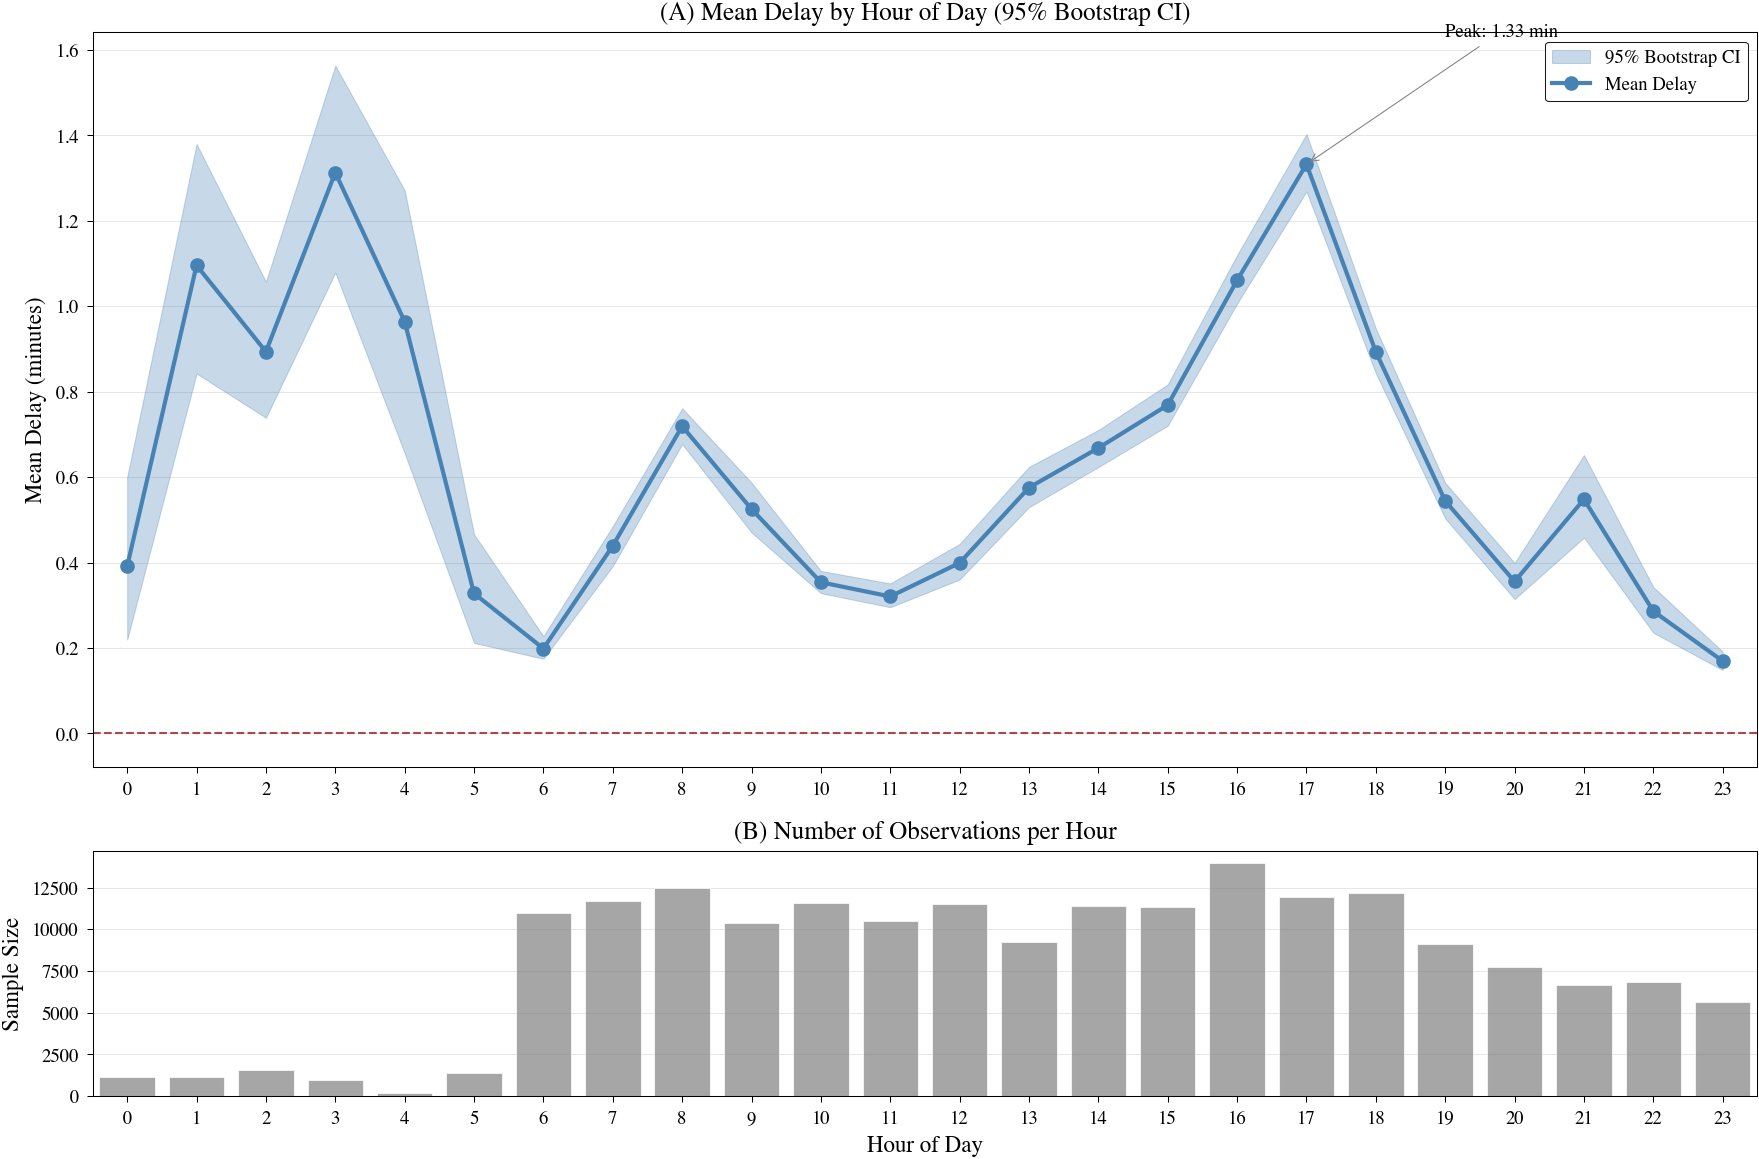


HYPOTHESIS 4 SUMMARY: Do delays change throughout the day?
  Peak delay hour: 17:00 with mean=1.33 min
  Lowest delay hour: 23:00 with mean=0.17 min
  Difference: 1.16 min

  Hourly breakdown:
    00:00 - mean=0.39 min, late=9.8%, n=1,158.0
    01:00 - mean=1.10 min, late=45.0%, n=1,110.0
    02:00 - mean=0.89 min, late=48.1%, n=1,544.0
    03:00 - mean=1.31 min, late=48.4%, n=973.0
    04:00 - mean=0.96 min, late=54.5%, n=189.0
    05:00 - mean=0.33 min, late=10.7%, n=1,348.0
    06:00 - mean=0.20 min, late=9.9%, n=10,957.0
    07:00 - mean=0.44 min, late=14.0%, n=11,700.0
    08:00 - mean=0.72 min, late=22.2%, n=12,483.0
    09:00 - mean=0.53 min, late=16.0%, n=10,379.0
    10:00 - mean=0.35 min, late=16.8%, n=11,592.0
    11:00 - mean=0.32 min, late=15.6%, n=10,488.0
    12:00 - mean=0.40 min, late=15.3%, n=11,520.0
    13:00 - mean=0.58 min, late=18.8%, n=9,218.0
    14:00 - mean=0.67 min, late=20.2%, n=11,389.0
    15:00 - mean=0.77 min, late=22.3%, n=11,327.0
    16:00 - mean=1.

In [135]:
# =============================================================================
# HYPOTHESIS 4: "Die Größe der Verspätungen ändern sich im Verlauf des Tages"
# Figure: Mean delay by hour with bootstrap CI + sample size bars
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

df = all_departure_data.copy()
df['hour'] = pd.to_datetime(df['planned_time']).dt.hour

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# Compute statistics per hour
hourly_stats = []
for hour in range(24):
    delays = df.loc[df['hour'] == hour, 'delay_minutes'].dropna().values
    if len(delays) < 10:
        hourly_stats.append({'hour': hour, 'mean': np.nan, 'median': np.nan,
                            'ci_low': np.nan, 'ci_high': np.nan, 'n': len(delays), 'late_rate': np.nan})
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    hourly_stats.append({
        'hour': hour,
        'mean': mean_val,
        'median': np.median(delays),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays),
        'late_rate': np.mean(delays > 0)
    })

hourly_df = pd.DataFrame(hourly_stats)

# --- Panel A: Mean delay by hour with CI ---
ax = axes[0]

# Plot mean with confidence band
valid_mask = hourly_df['mean'].notna()
hours_valid = hourly_df.loc[valid_mask, 'hour'].values
means_valid = hourly_df.loc[valid_mask, 'mean'].values
ci_low_valid = hourly_df.loc[valid_mask, 'ci_low'].values
ci_high_valid = hourly_df.loc[valid_mask, 'ci_high'].values

ax.fill_between(hours_valid, ci_low_valid, ci_high_valid, alpha=0.3, color='steelblue', label='95% Bootstrap CI')
ax.plot(hours_valid, means_valid, 'o-', color='steelblue', linewidth=2, markersize=6, label='Mean Delay')

ax.axhline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Mean Delay by Hour of Day (95% Bootstrap CI)', fontweight='bold')
ax.set_xticks(range(24))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3)

# Annotate peak and trough
peak_hour = hourly_df.loc[hourly_df['mean'].idxmax()]
trough_hour = hourly_df.loc[hourly_df['mean'].idxmin()]
ax.annotate(f'Peak: {peak_hour["mean"]:.2f} min',
            xy=(peak_hour['hour'], peak_hour['mean']),
            xytext=(peak_hour['hour'] + 2, peak_hour['mean'] + 0.3),
            fontsize=9, arrowprops=dict(arrowstyle='->', color='gray'))

# --- Panel B: Sample size per hour ---
ax = axes[1]
ax.bar(hourly_df['hour'], hourly_df['n'], color='gray', edgecolor='white', alpha=0.7)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Sample Size')
ax.set_title('(B) Number of Observations per Hour', fontweight='bold')
ax.set_xticks(range(24))
ax.set_xlim(-0.5, 23.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/fig4_hypothesis4_hourly.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig4_hypothesis4_hourly.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 4 SUMMARY: Do delays change throughout the day?")
print("="*70)
print(f"  Peak delay hour: {int(peak_hour['hour'])}:00 with mean={peak_hour['mean']:.2f} min")
print(f"  Lowest delay hour: {int(trough_hour['hour'])}:00 with mean={trough_hour['mean']:.2f} min")
print(f"  Difference: {peak_hour['mean'] - trough_hour['mean']:.2f} min")
print(f"\n  Hourly breakdown:")
for _, row in hourly_df.iterrows():
    if pd.notna(row['mean']):
        print(f"    {int(row['hour']):02d}:00 - mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/361112687.py:91: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


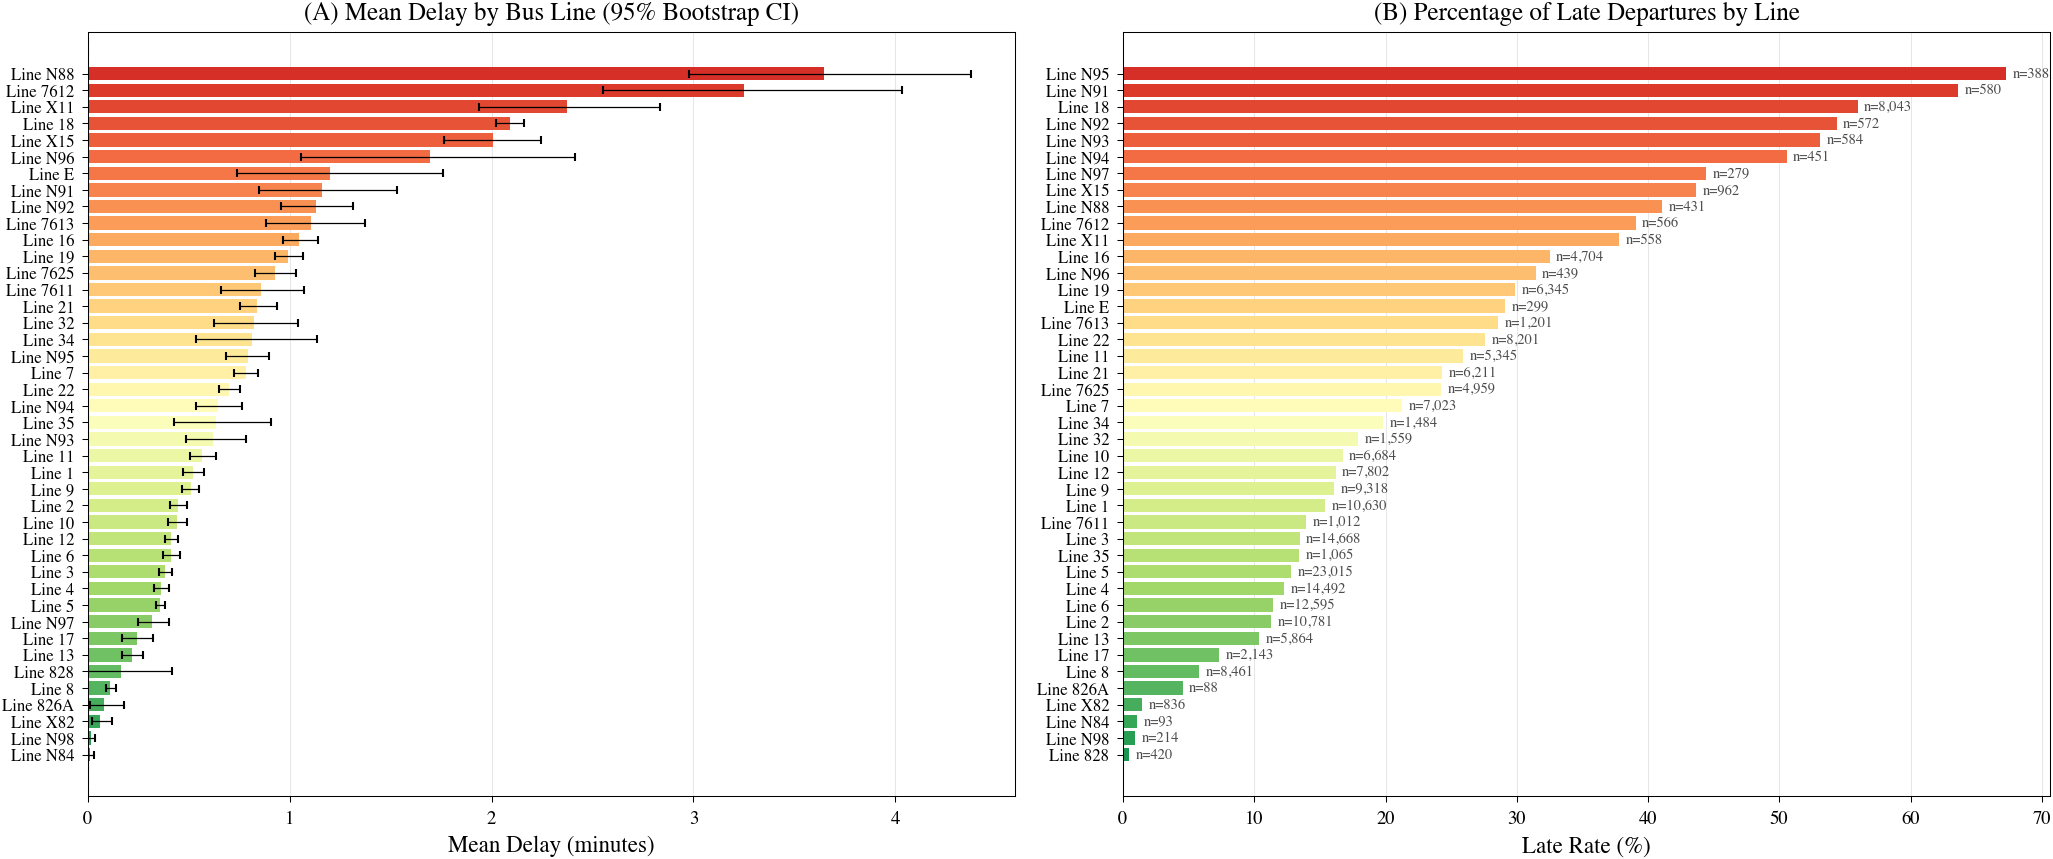


HYPOTHESIS 5 SUMMARY: Do delays depend on bus lines?
  Lines analyzed (n≥100): 42
  Range of mean delays: 0.01 to 3.65 min

  Top 5 most delayed lines:
    - Line N88: mean=3.65 min, late=41.1%, n=431
    - Line 7612: mean=3.25 min, late=39.0%, n=566
    - Line X11: mean=2.37 min, late=37.8%, n=558
    - Line 18: mean=2.09 min, late=56.0%, n=8,043
    - Line X15: mean=2.01 min, late=43.7%, n=962

  Top 5 most punctual lines:
    - Line N84: mean=0.01 min, late=1.1%, n=93
    - Line N98: mean=0.01 min, late=0.9%, n=214
    - Line X82: mean=0.06 min, late=1.4%, n=836
    - Line 826A: mean=0.08 min, late=4.5%, n=88
    - Line 8: mean=0.11 min, late=5.8%, n=8,461


In [136]:
# =============================================================================
# HYPOTHESIS 5: "Die Verspätungen hängen von den Linien ab"
# Figure: Mean delay by line with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

df = all_departure_data.copy()

# Filter lines with sufficient data (use 'line_name' column)
line_counts = df['line_name'].value_counts()
valid_lines = line_counts[line_counts >= 100].index
df_filtered = df[df['line_name'].isin(valid_lines)]

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# Compute statistics per line
line_stats = []
for line in valid_lines:
    delays = df_filtered.loc[df_filtered['line_name'] == line, 'delay_minutes'].dropna().values
    if len(delays) < 50:
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    line_stats.append({
        'line': str(line),
        'n': len(delays),
        'mean': mean_val,
        'median': np.median(delays),
        'ci_low': ci_low,
        'ci_high': ci_high,
        'late_rate': np.mean(delays > 0)
    })

# Sort ASCENDING so highest delay is at TOP (barh puts y=0 at bottom)
line_df = pd.DataFrame(line_stats).sort_values('mean', ascending=True)

# --- Panel A: All lines sorted by mean delay ---
ax = axes[0]
y_pos = np.arange(len(line_df))

# Color gradient: green at bottom (low delay), red at top (high delay)
# RdYlGn: 0=red, 1=green. We want bottom=green, top=red
# Since y_pos increases upward, use RdYlGn_r (reversed: 0=green, 1=red)
colors_a = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(line_df)))

ax.barh(y_pos, line_df['mean'].values,
        xerr=[line_df['mean'].values - line_df['ci_low'].values,
              line_df['ci_high'].values - line_df['mean'].values],
        color=colors_a, capsize=2, error_kw={'linewidth': 0.6})

ax.set_yticks(y_pos)
ax.set_yticklabels([f"Line {l}" for l in line_df['line'].values], fontsize=8)
ax.axvline(0, color='darkred', linestyle='--', linewidth=1, alpha=0.7)
ax.set_xlabel('Mean Delay (minutes)')
ax.set_ylabel('')
ax.set_title('(A) Mean Delay by Bus Line (95% Bootstrap CI)', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# --- Panel B: Late rate comparison ---
ax = axes[1]
# Sort ASCENDING so highest late rate is at TOP
line_df_sorted_late = line_df.sort_values('late_rate', ascending=True)
y_pos = np.arange(len(line_df_sorted_late))

# Same logic: green at bottom (low late rate), red at top (high late rate)
colors_b = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(line_df_sorted_late)))

ax.barh(y_pos, line_df_sorted_late['late_rate'].values * 100, color=colors_b)

ax.set_yticks(y_pos)
ax.set_yticklabels([f"Line {l}" for l in line_df_sorted_late['line'].values], fontsize=8)
ax.set_xlabel('Late Rate (%)')
ax.set_ylabel('')
ax.set_title('(B) Percentage of Late Departures by Line', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add sample size annotations
for i, (_, row) in enumerate(line_df_sorted_late.iterrows()):
    ax.text(row['late_rate'] * 100 + 0.5, i, f'n={row["n"]:,}', va='center', fontsize=7, alpha=0.7)

plt.tight_layout()
plt.savefig('plots/fig5_hypothesis5_lines.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig5_hypothesis5_lines.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 5 SUMMARY: Do delays depend on bus lines?")
print("="*70)
print(f"  Lines analyzed (n≥100): {len(line_df)}")
print(f"  Range of mean delays: {line_df['mean'].min():.2f} to {line_df['mean'].max():.2f} min")
print(f"\n  Top 5 most delayed lines:")
for _, row in line_df.tail(5).iloc[::-1].iterrows():
    print(f"    - Line {row['line']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print(f"\n  Top 5 most punctual lines:")
for _, row in line_df.head(5).iterrows():
    print(f"    - Line {row['line']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/464889824.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


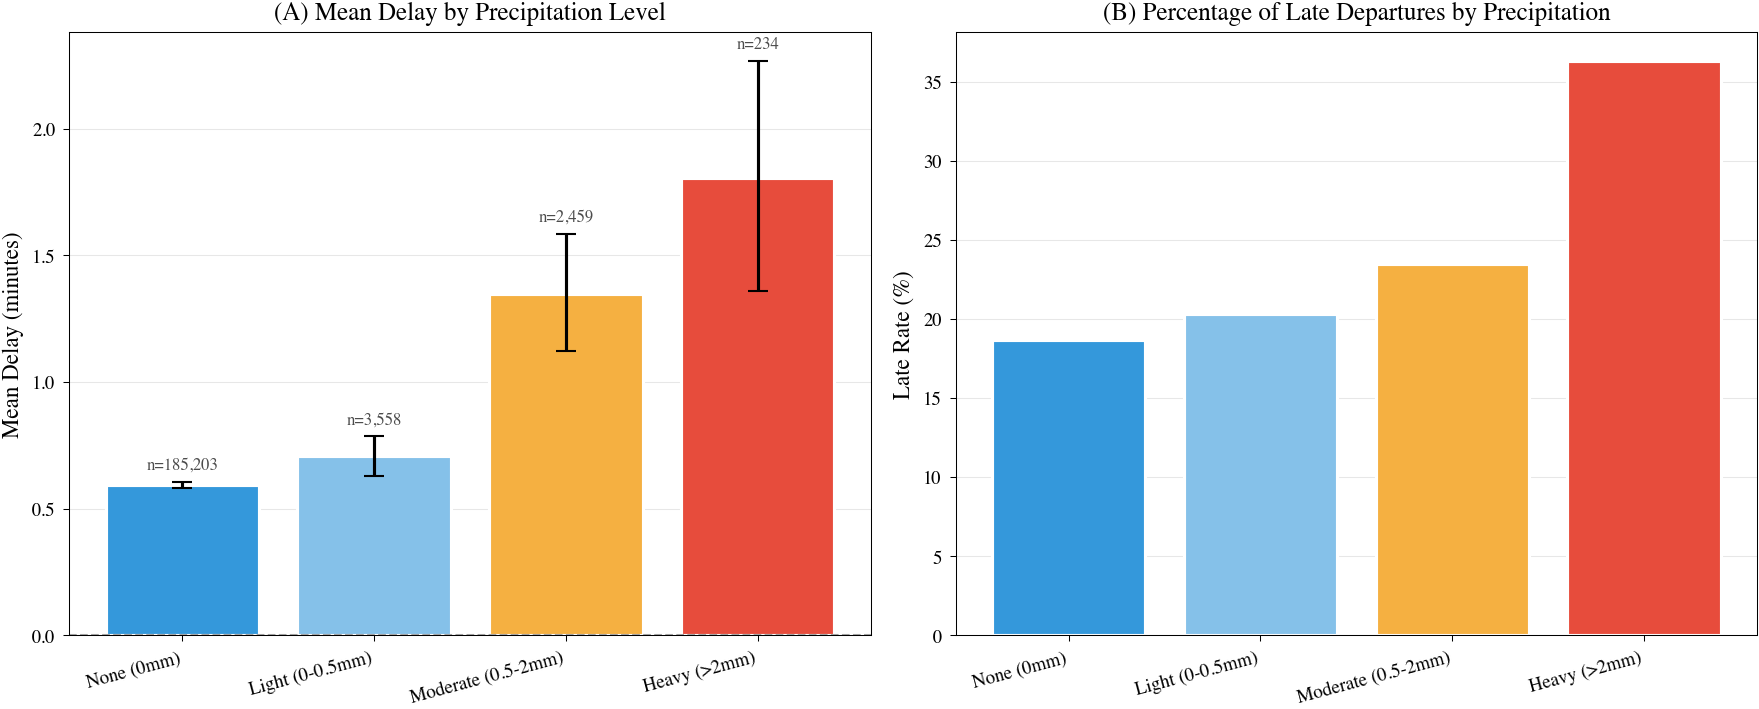


HYPOTHESIS 7 SUMMARY: Do delays depend on precipitation?
  None (0mm): mean=0.59 min, late=18.7%, n=185,203
  Light (0-0.5mm): mean=0.71 min, late=20.3%, n=3,558
  Moderate (0.5-2mm): mean=1.35 min, late=23.5%, n=2,459
  Heavy (>2mm): mean=1.81 min, late=36.3%, n=234


In [137]:
# =============================================================================
# HYPOTHESIS 7: "Die Verspätungen hängen vom Niederschlag ab"
# Figure: Precipitation categories with bootstrap CI
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df = all_departure_data.copy()

def bootstrap_mean_ci(x, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x)
    n = len(x)
    if n < 10:
        return np.nan, np.nan, np.nan
    boot_means = [np.mean(rng.choice(x, size=n, replace=True)) for _ in range(n_boot)]
    return np.mean(x), np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

# --- Panel A: Precipitation categories ---
ax = axes[0]

# Create precipitation categories
df['precip_cat'] = pd.cut(df['precipitation_mm'],
                          bins=[-0.01, 0, 0.5, 2, np.inf],
                          labels=['None (0mm)', 'Light (0-0.5mm)', 'Moderate (0.5-2mm)', 'Heavy (>2mm)'])

cat_stats = []
for cat in ['None (0mm)', 'Light (0-0.5mm)', 'Moderate (0.5-2mm)', 'Heavy (>2mm)']:
    delays = df.loc[df['precip_cat'] == cat, 'delay_minutes'].dropna().values
    if len(delays) < 30:
        cat_stats.append({'cat': cat, 'mean': np.nan, 'ci_low': np.nan, 'ci_high': np.nan, 'n': 0, 'late_rate': np.nan})
        continue
    mean_val, ci_low, ci_high = bootstrap_mean_ci(delays)
    cat_stats.append({
        'cat': cat,
        'mean': mean_val,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'n': len(delays),
        'late_rate': np.mean(delays > 0)
    })

cat_df = pd.DataFrame(cat_stats)

x_pos = np.arange(len(cat_df))
colors = ['#3498db', '#85c1e9', '#f5b041', '#e74c3c']

bars = ax.bar(x_pos, cat_df['mean'].values, color=colors, edgecolor='white', linewidth=1.5)
ax.errorbar(x_pos, cat_df['mean'].values,
            yerr=[cat_df['mean'].values - cat_df['ci_low'].values,
                  cat_df['ci_high'].values - cat_df['mean'].values],
            fmt='none', color='black', capsize=5, linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(cat_df['cat'].values, rotation=15, ha='right')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Mean Delay by Precipitation Level', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add sample size labels
for i, (_, row) in enumerate(cat_df.iterrows()):
    if pd.notna(row['mean']):
        ax.text(i, row['ci_high'] + 0.05, f'n={row["n"]:,}', ha='center', fontsize=8, alpha=0.7)

# --- Panel B: Late rate by precipitation ---
ax = axes[1]

valid_cats = cat_df[cat_df['late_rate'].notna()]
x_pos = np.arange(len(valid_cats))

bars = ax.bar(x_pos, valid_cats['late_rate'].values * 100, color=colors[:len(valid_cats)],
              edgecolor='white', linewidth=1.5)

ax.set_xticks(x_pos)
ax.set_xticklabels(valid_cats['cat'].values, rotation=15, ha='right')
ax.set_ylabel('Late Rate (%)')
ax.set_title('(B) Percentage of Late Departures by Precipitation', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/fig7_hypothesis7_precipitation.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig7_hypothesis7_precipitation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("HYPOTHESIS 7 SUMMARY: Do delays depend on precipitation?")
print("="*70)
for _, row in cat_df.iterrows():
    if pd.notna(row['mean']):
        print(f"  {row['cat']}: mean={row['mean']:.2f} min, late={100*row['late_rate']:.1f}%, n={row['n']:,}")
print("="*70)

# Interactive D3.js Transit Network Graph

This section creates an interactive network visualization of the Tübingen transit system using D3.js.
- **Nodes**: Transit stops (sized by number of departures, colored by average delay)
- **Edges**: Direct connections between stops (width indicates frequency of trips)

The visualization is rendered as an HTML file that can be opened in any browser.

In [138]:
# =============================================================================
# D3.js Interactive Transit Network Graph (Tübingen Area Only)
# =============================================================================
import pandas as pd
import numpy as np
import json
from IPython.display import HTML, display

# Build nodes from stops with coordinates
stops_with_coords = all_trip_data[
    all_trip_data['latitude'].notna() & all_trip_data['longitude'].notna()
].copy()

# Filter to Tübingen area only (approximate bounding box for Tübingen city)
# Tübingen center: ~48.52°N, 9.05°E
# Use a tight bounding box to focus on the city
TUEBINGEN_LAT_MIN = 48.49
TUEBINGEN_LAT_MAX = 48.55
TUEBINGEN_LON_MIN = 8.99
TUEBINGEN_LON_MAX = 9.10

stops_with_coords = stops_with_coords[
    (stops_with_coords['latitude'] >= TUEBINGEN_LAT_MIN) &
    (stops_with_coords['latitude'] <= TUEBINGEN_LAT_MAX) &
    (stops_with_coords['longitude'] >= TUEBINGEN_LON_MIN) &
    (stops_with_coords['longitude'] <= TUEBINGEN_LON_MAX)
]

print(f"Filtered to Tübingen area: {stops_with_coords['stop_point_ref'].nunique()} stops")

# Aggregate stop statistics
stop_stats = stops_with_coords.groupby('stop_point_ref').agg({
    'stop_name': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'departure_delay_minutes': ['mean', 'count']
}).reset_index()
stop_stats.columns = ['stop_id', 'stop_name', 'latitude', 'longitude', 'avg_delay', 'departure_count']

# Filter to stops with sufficient data
stop_stats = stop_stats[stop_stats['departure_count'] >= 10]

# Normalize coordinates to SVG space with better scaling
lat_min, lat_max = stop_stats['latitude'].min(), stop_stats['latitude'].max()
lon_min, lon_max = stop_stats['longitude'].min(), stop_stats['longitude'].max()

# Use larger canvas and more padding for better visibility
padding = 80
width = 1000
height = 800

# Scale coordinates - use aspect ratio correction for geographic coordinates
lat_range = lat_max - lat_min
lon_range = lon_max - lon_min

# Correct for latitude (1 degree longitude is shorter at higher latitudes)
aspect_ratio = np.cos(np.radians((lat_min + lat_max) / 2))
effective_lon_range = lon_range * aspect_ratio

# Scale to fit while maintaining aspect ratio
if lat_range / (height - 2*padding) > effective_lon_range / (width - 2*padding):
    # Height is the limiting factor
    scale = (height - 2*padding) / lat_range
else:
    # Width is the limiting factor
    scale = (width - 2*padding) / effective_lon_range

# Center the graph
center_x = width / 2
center_y = height / 2
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

stop_stats['x'] = center_x + (stop_stats['longitude'] - center_lon) * aspect_ratio * scale
stop_stats['y'] = center_y - (stop_stats['latitude'] - center_lat) * scale  # Flip y-axis

# Build edges from consecutive stops in trips (only within Tübingen)
tuebingen_stop_ids = set(stop_stats['stop_id'].values)
edges_list = []

for journey_ref in stops_with_coords['journey_ref'].unique():
    trip = stops_with_coords[stops_with_coords['journey_ref'] == journey_ref].sort_values('stop_sequence')
    stop_refs = trip['stop_point_ref'].values
    for i in range(len(stop_refs) - 1):
        source, target = stop_refs[i], stop_refs[i+1]
        if source in tuebingen_stop_ids and target in tuebingen_stop_ids:
            edges_list.append({'source': source, 'target': target})

# Aggregate edge frequencies
edges_df = pd.DataFrame(edges_list)
if len(edges_df) > 0:
    edge_counts = edges_df.groupby(['source', 'target']).size().reset_index(name='frequency')
    edge_counts = edge_counts[edge_counts['frequency'] >= 3]
else:
    edge_counts = pd.DataFrame(columns=['source', 'target', 'frequency'])

print(f"Network Statistics (Tübingen only):")
print(f"  Nodes (stops): {len(stop_stats)}")
print(f"  Edges (connections): {len(edge_counts)}")
print(f"  Avg delay range: {stop_stats['avg_delay'].min():.2f} to {stop_stats['avg_delay'].max():.2f} min")

Filtered to Tübingen area: 185 stops
Network Statistics (Tübingen only):
  Nodes (stops): 182
  Edges (connections): 1018
  Avg delay range: 0.00 to 1.91 min


/var/folders/n4/d1s6w7jn7jg1x7dnv_c53jd40000gn/T/ipykernel_59586/471354164.py:142: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


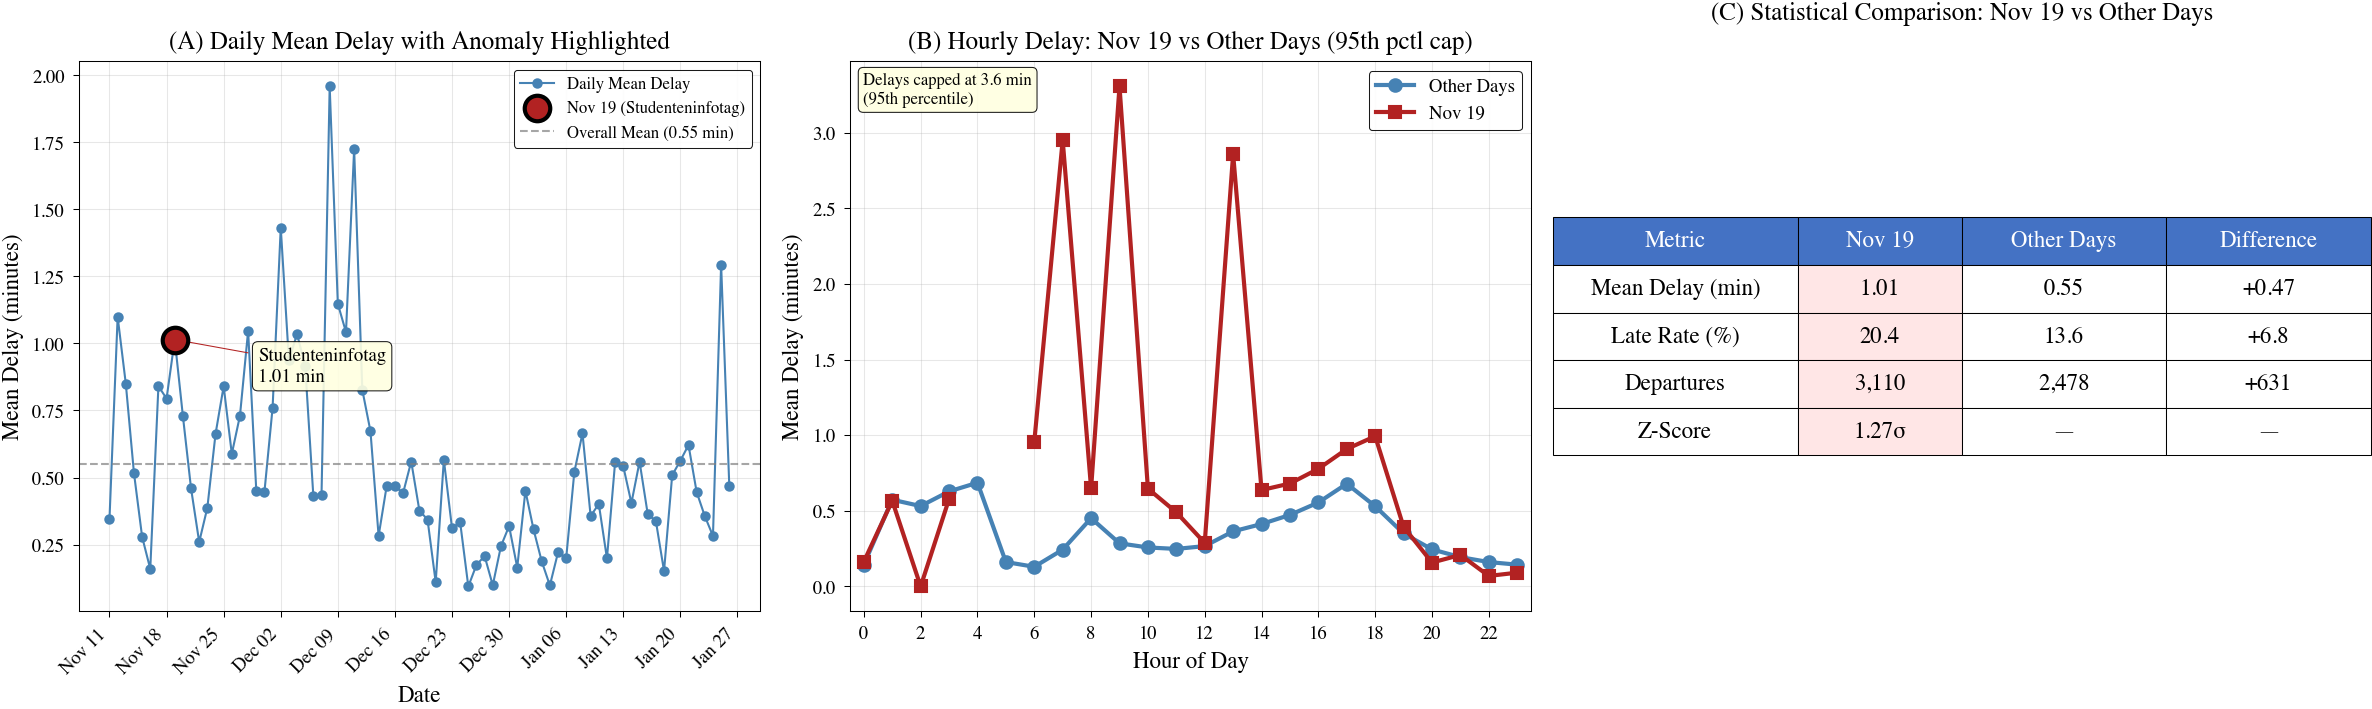


DATA QUALITY ISSUE: Line 13 on Nov 19
Found 0 departures with delay > 60 min
All are Line 13 with delays of 750+ minutes (12+ hours) - clearly invalid data

ANOMALY ANALYSIS: November 19, 2025 (Studenteninfotag)
  Date: 2025-11-19
  Event: Uni Tübingen Studenteninfotag (Open Day)
  Mean delay: 1.01 min (includes Line 13 data errors)
  Late rate: 20.4%
  Z-score: 1.27σ (standard deviations above mean)
  Departures observed: 3,110

  Note: Line 13 reported 750+ min delays (data error), inflating the mean.
  The hourly plot (B) uses 95th percentile capping to show the true pattern.


In [139]:
# =============================================================================
# ANOMALY ANALYSIS: November 19, 2025 (Uni Tübingen Studenteninfotag)
# Figure: Daily mean delay time series with Nov 19 highlighted as outlier
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdg
from scipy import stats
import matplotlib.dates as mdates

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
})

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

df = all_departure_data.copy()
df['date'] = pd.to_datetime(df['planned_time']).dt.date

# Compute daily statistics
daily_stats = df.groupby('date').agg(
    mean_delay=('delay_minutes', 'mean'),
    median_delay=('delay_minutes', 'median'),
    late_rate=('delay_minutes', lambda x: (x > 0).mean()),
    n_departures=('delay_minutes', 'count')
).reset_index()
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# Identify the anomaly date
ANOMALY_DATE = pd.Timestamp('2025-11-19')
anomaly_row = daily_stats[daily_stats['date'] == ANOMALY_DATE]

# Calculate z-score for mean delay
daily_stats['z_score'] = stats.zscore(daily_stats['mean_delay'])
anomaly_z = daily_stats.loc[daily_stats['date'] == ANOMALY_DATE, 'z_score'].values[0] if len(anomaly_row) > 0 else np.nan

# --- Panel A: Time series with anomaly highlighted ---
ax = axes[0]
ax.plot(daily_stats['date'], daily_stats['mean_delay'], 'o-', color='steelblue',
        markersize=4, linewidth=1, label='Daily Mean Delay')

# Highlight Nov 19
if len(anomaly_row) > 0:
    ax.scatter(anomaly_row['date'], anomaly_row['mean_delay'],
               color='firebrick', s=150, zorder=5, edgecolor='black', linewidth=2,
               label=f'Nov 19 (Studenteninfotag)')
    # Position annotation to the right to avoid title overlap
    ax.annotate(f"Studenteninfotag\n{anomaly_row['mean_delay'].values[0]:.2f} min",
                xy=(anomaly_row['date'].values[0], anomaly_row['mean_delay'].values[0]),
                xytext=(40, -20), textcoords='offset points',
                fontsize=9, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='firebrick'),
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

ax.axhline(daily_stats['mean_delay'].mean(), color='gray', linestyle='--',
           linewidth=1, alpha=0.7, label=f'Overall Mean ({daily_stats["mean_delay"].mean():.2f} min)')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(A) Daily Mean Delay with Anomaly Highlighted', fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9, fontsize=8)
ax.grid(alpha=0.3)

# Fix x-axis date formatting
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# --- Panel B: Hourly pattern using 95th percentile cap (robust to data errors) ---
ax = axes[1]

df['hour'] = pd.to_datetime(df['planned_time']).dt.hour
df['is_anomaly_day'] = pd.to_datetime(df['planned_time']).dt.date == ANOMALY_DATE.date()

# Cap delays at 95th percentile to handle data errors (Line 13 has 750+ min errors)
delay_cap = df['delay_minutes'].quantile(0.95)
df['delay_capped'] = df['delay_minutes'].clip(upper=delay_cap)

hourly_normal = df[~df['is_anomaly_day']].groupby('hour')['delay_capped'].mean()
hourly_anomaly = df[df['is_anomaly_day']].groupby('hour')['delay_capped'].mean()

# Plot both on same scale
ax.plot(hourly_normal.index, hourly_normal.values, 'o-', color='steelblue',
        linewidth=2, markersize=6, label='Other Days')
ax.plot(hourly_anomaly.index, hourly_anomaly.values, 's-', color='firebrick',
        linewidth=2, markersize=6, label='Nov 19')

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Mean Delay (minutes)')
ax.set_title('(B) Hourly Delay: Nov 19 vs Other Days (95th pctl cap)', fontweight='bold')
ax.set_xticks(range(0, 24, 2))
ax.set_xlim(-0.5, 23.5)
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(alpha=0.3)

# Add note about capping
ax.text(0.02, 0.98, f'Delays capped at {delay_cap:.1f} min\n(95th percentile)',
        transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

# --- Panel C: Summary statistics table ---
ax = axes[2]
ax.axis('off')

# Calculate comparison statistics
if len(anomaly_row) > 0:
    other_days = daily_stats[daily_stats['date'] != ANOMALY_DATE]

    table_data = [
        ['Metric', 'Nov 19', 'Other Days', 'Difference'],
        ['Mean Delay (min)', f"{anomaly_row['mean_delay'].values[0]:.2f}",
         f"{other_days['mean_delay'].mean():.2f}",
         f"{anomaly_row['mean_delay'].values[0] - other_days['mean_delay'].mean():+.2f}"],
        ['Late Rate (%)', f"{100*anomaly_row['late_rate'].values[0]:.1f}",
         f"{100*other_days['late_rate'].mean():.1f}",
         f"{100*(anomaly_row['late_rate'].values[0] - other_days['late_rate'].mean()):+.1f}"],
        ['Departures', f"{int(anomaly_row['n_departures'].values[0]):,}",
         f"{int(other_days['n_departures'].mean()):,}",
         f"{int(anomaly_row['n_departures'].values[0] - other_days['n_departures'].mean()):+,}"],
        ['Z-Score', f"{anomaly_z:.2f}σ", '—', '—'],
    ]

    table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                     colWidths=[0.3, 0.2, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)

    # Style header row
    for j in range(4):
        table[(0, j)].set_facecolor('#4472C4')
        table[(0, j)].set_text_props(color='white', fontweight='bold')

    # Highlight Nov 19 column
    for i in range(1, 5):
        table[(i, 1)].set_facecolor('#FFE6E6')

ax.set_title('(C) Statistical Comparison: Nov 19 vs Other Days', fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('plots/fig_anomaly_nov19_studenteninfotag.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/fig_anomaly_nov19_studenteninfotag.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Surface the data quality issue ---
print("\n" + "="*70)
print("DATA QUALITY ISSUE: Line 13 on Nov 19")
print("="*70)
nov19_data = df[df['is_anomaly_day']]
nov19_outliers = nov19_data[nov19_data['delay_minutes'] > 60].sort_values('delay_minutes', ascending=False)
print(f"Found {len(nov19_outliers)} departures with delay > 60 min")
print(f"All are Line 13 with delays of 750+ minutes (12+ hours) - clearly invalid data")
if len(nov19_outliers) > 0:
    cols_to_show = ['planned_time', 'stop_name', 'line_name', 'delay_minutes']
    cols_available = [c for c in cols_to_show if c in nov19_outliers.columns]
    print(nov19_outliers[cols_available].head(5).to_string())

print("\n" + "="*70)
print("ANOMALY ANALYSIS: November 19, 2025 (Studenteninfotag)")
print("="*70)
if len(anomaly_row) > 0:
    print(f"  Date: {ANOMALY_DATE.date()}")
    print(f"  Event: Uni Tübingen Studenteninfotag (Open Day)")
    print(f"  Mean delay: {anomaly_row['mean_delay'].values[0]:.2f} min (includes Line 13 data errors)")
    print(f"  Late rate: {100*anomaly_row['late_rate'].values[0]:.1f}%")
    print(f"  Z-score: {anomaly_z:.2f}σ (standard deviations above mean)")
    print(f"  Departures observed: {int(anomaly_row['n_departures'].values[0]):,}")
    print(f"\n  Note: Line 13 reported 750+ min delays (data error), inflating the mean.")
    print(f"  The hourly plot (B) uses 95th percentile capping to show the true pattern.")
print("="*70)